# Business Case - HotelSmart

Os canais de reserva de hotéis online transformaram significativamente
a maneira como os clientes fazem suas reservas e também o
comportamento deles em relação a essas reservas. Atualmente, um
número considerável de reservas são canceladas, seja por decisão dos
clientes ou por não comparecimento.

Os motivos típicos para cancelamentos incluem mudanças de planos,
conflitos de horários, entre outros. Muitas vezes, esses cancelamentos
são facilitados pela opção de cancelar gratuitamente ou a um custo
muito baixo. Embora essa flexibilidade seja benéfica para os hóspedes,
representando uma comodidade e segurança em suas reservas, para os
hotéis, isso pode se traduzir em um desafio financeiro e operacional

Nesse contexto, você trabalha como Cientista de Dados para a empresa
fictícia HotelSmart e o CEO está preocupado com a alta taxa de
cancelamento de reservas, que tem um custo médio de R$3500 por
cancelamento. Com a estimativa de 50,000 reservas para o próximo
ano, os cancelamentos representam um desafio significativo tanto
financeiro quanto operacional.
O objetivo deste desafio é desenvolver um modelo de Machine Learning
capaz de prever com precisão se uma reserva será cancelada ou não. A
previsão precisa dos cancelamentos permitirá à HotelSmart adotar
medidas proativas para reduzir o impacto dos cancelamentos, otimizar a
ocupação dos quartos e, consequentemente, aumentar a lucratividade.

# Imports

In [190]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import pickle
import requests
import json
from flask import Flask, request, Response
import os

# Functions

In [191]:
%matplotlib inline
%pylab inline
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width: 100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
jupyter_settings()


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def calculate_metrics(nome_algoritmo, y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    df = pd.DataFrame({
        'Algoritmo': [nome_algoritmo],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy]
    })

    return df
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    modelos = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    resultados = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        resultado = calculate_metrics(nome, y_test, y_pred)
        resultados.append(resultado)

    return pd.concat(resultados, ignore_index=True)
def rescale_robust(data, column_name):
    scaler = RobustScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])
    pickle.dump(scaler, open('parameter/' + column_name + '_scaler.pkl', 'wb'))
    return data
def encoding_ordinal(data, column_name):
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    data[[column_name]] = encoder.fit_transform(data[[column_name]])
    pickle.dump(encoder, open(f'parameter/{column_name}_encoder.pkl', 'wb'))
    return data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data Load

In [74]:
df = pd.read_csv("hotel.csv")

# 1.0 Data Description

In [75]:
# Gerando uma copia do df original
df1 = df.copy()
df1.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [76]:
# 1.2 Tipos
df1.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [77]:
# Transformando a variavel target
df1["booking_status"] = df1["booking_status"].map({"Not_Canceled": 0, "Canceled": 1})

In [78]:
# Verificar valores ausentes
missing_values = df1.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

### 1.5 Estatistica Descritiva

In [79]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

In [80]:
# Medidas de tendencia central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# medidas de dispersão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


# Percentis
percentiles25 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 25))).T
percentiles75 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 75))).T
percentiles85 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 85))).T
percentiles90 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 90))).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, percentiles25, percentiles75, percentiles85, percentiles90]).T.reset_index()
m.columns = ['columns','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'percentiles25', 'percentiles75', 'percentiles85', 'percentiles90']



In [81]:
m

,columns,min,max,range,mean,median,std,skew,kurtosis,percentiles25,percentiles75,percentiles85,percentiles90
0,no_of_adults,0.0,4.0,4.0,1.844962,2.00,0.518708,-0.333295,0.814822,2.0,2.0,2.0,2.000
1,no_of_children,0.0,10.0,10.0,0.105279,0.00,0.402643,4.710350,36.981856,0.0,0.0,0.0,0.000
2,no_of_weekend_nights,0.0,7.0,7.0,0.810724,1.00,0.870632,0.737616,0.298858,0.0,2.0,2.0,2.000
3,no_of_week_nights,0.0,17.0,17.0,2.204300,2.00,1.410885,1.599350,7.798284,1.0,3.0,3.0,4.000
4,required_car_parking_space,0.0,1.0,1.0,0.030986,0.00,0.173278,5.413643,27.309037,0.0,0.0,0.0,0.000
5,lead_time,0.0,443.0,443.0,85.232557,57.00,85.929632,1.292492,1.179594,17.0,126.0,179.0,213.000
6,arrival_year,2017.0,2018.0,1.0,2017.820427,2018.00,0.383831,-1.669695,0.787926,2018.0,2018.0,2018.0,2018.000
7,arrival_month,1.0,12.0,11.0,7.423653,8.00,3.069852,-0.348229,-0.933189,5.0,10.0,11.0,11.000
8,arrival_date,1.0,31.0,30.0,15.596995,16.00,8.740327,0.028809,-1.157214,8.0,23.0,26.0,28.000
9,repeated_guest,0.0,1.0,1.0,0.025637,0.00,0.158051,6.002888,34.036545,0.0,0.0,0.0,0.000


In [82]:
cat_attributes.describe()

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type
count,36275,36275,36275,36275
unique,36275,4,7,5
top,INN00001,Meal Plan 1,Room_Type 1,Online
freq,1,27835,28130,23214


### 1.6 Dados Faltantes

In [83]:
df1.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [84]:
# Substituição com machine learning
imputer = KNNImputer()
df_imputed = pd.DataFrame(imputer.fit_transform(num_attributes), columns=num_attributes.columns)
df1 = pd.concat([df_imputed, cat_attributes], axis=1)
pickle.dump(imputer, open('parameter/imputer_knn.pkl', 'wb'))

# 2.0 Feature Engineering

In [85]:
# Gerando uma segunda copia do df1 por segurança
df2 = df1.copy()

In [86]:

df2["total_nights"] = df2["no_of_weekend_nights"] + df2["no_of_week_nights"]
df2["total_guests"] = df2["no_of_adults"] + df2["no_of_children"]
df["lead_time_category"] = pd.cut(df["lead_time"], bins=[-1, 7, 30, 90, 180, 365, 500],
                                    labels=["curto", "baixo", "medio", "alto", "muito_alto", "extremo"])
df2["is_group_booking"] = (df2["total_guests"] >= 4).astype(int)
df2["total_prev_interactions"] = df2["no_of_previous_cancellations"] + df["no_of_previous_bookings_not_canceled"]
df2["has_children"] = (df2["no_of_children"] > 0).astype(int)
df2["has_meal_plan"] = (df2["type_of_meal_plan"] != "Not Selected").astype(int)
df2["is_high_season"] = df2["arrival_month"].isin([1, 7, 8, 12]).astype(int)
df2["had_prev_cancel"] = (df2["no_of_previous_cancellations"] > 0).astype(int)
df2["had_prev_booking"] = (df2["no_of_previous_bookings_not_canceled"] > 0).astype(int)
df2["is_repeated_guest"] = (df2["repeated_guest"] == 1).astype(int)

In [87]:
df2.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest
0,2.0,0.0,1.0,2.0,0.0,224.0,2017.0,10.0,2.0,0.0,0.0,0.0,65.00,0.0,0.0,INN00001,Meal Plan 1,Room_Type 1,Offline,3.0,2.0,0,0.0,0,1,0,0,0,0
1,2.0,0.0,2.0,3.0,0.0,5.0,2018.0,11.0,6.0,0.0,0.0,0.0,106.68,1.0,0.0,INN00002,Not Selected,Room_Type 1,Online,5.0,2.0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,2018.0,2.0,28.0,0.0,0.0,0.0,60.00,0.0,1.0,INN00003,Meal Plan 1,Room_Type 1,Online,3.0,1.0,0,0.0,0,1,0,0,0,0
3,2.0,0.0,0.0,2.0,0.0,211.0,2018.0,5.0,20.0,0.0,0.0,0.0,100.00,0.0,1.0,INN00004,Meal Plan 1,Room_Type 1,Online,2.0,2.0,0,0.0,0,1,0,0,0,0
4,2.0,0.0,1.0,1.0,0.0,48.0,2018.0,4.0,11.0,0.0,0.0,0.0,94.50,0.0,1.0,INN00005,Not Selected,Room_Type 1,Online,2.0,2.0,0,0.0,0,0,0,0,0,0


# 3.0 Analise Exploratoria de Dados

In [88]:
df3 = df2.copy()

## 3.1 Analise Univariada

### 3.1.1 Variável Resposta

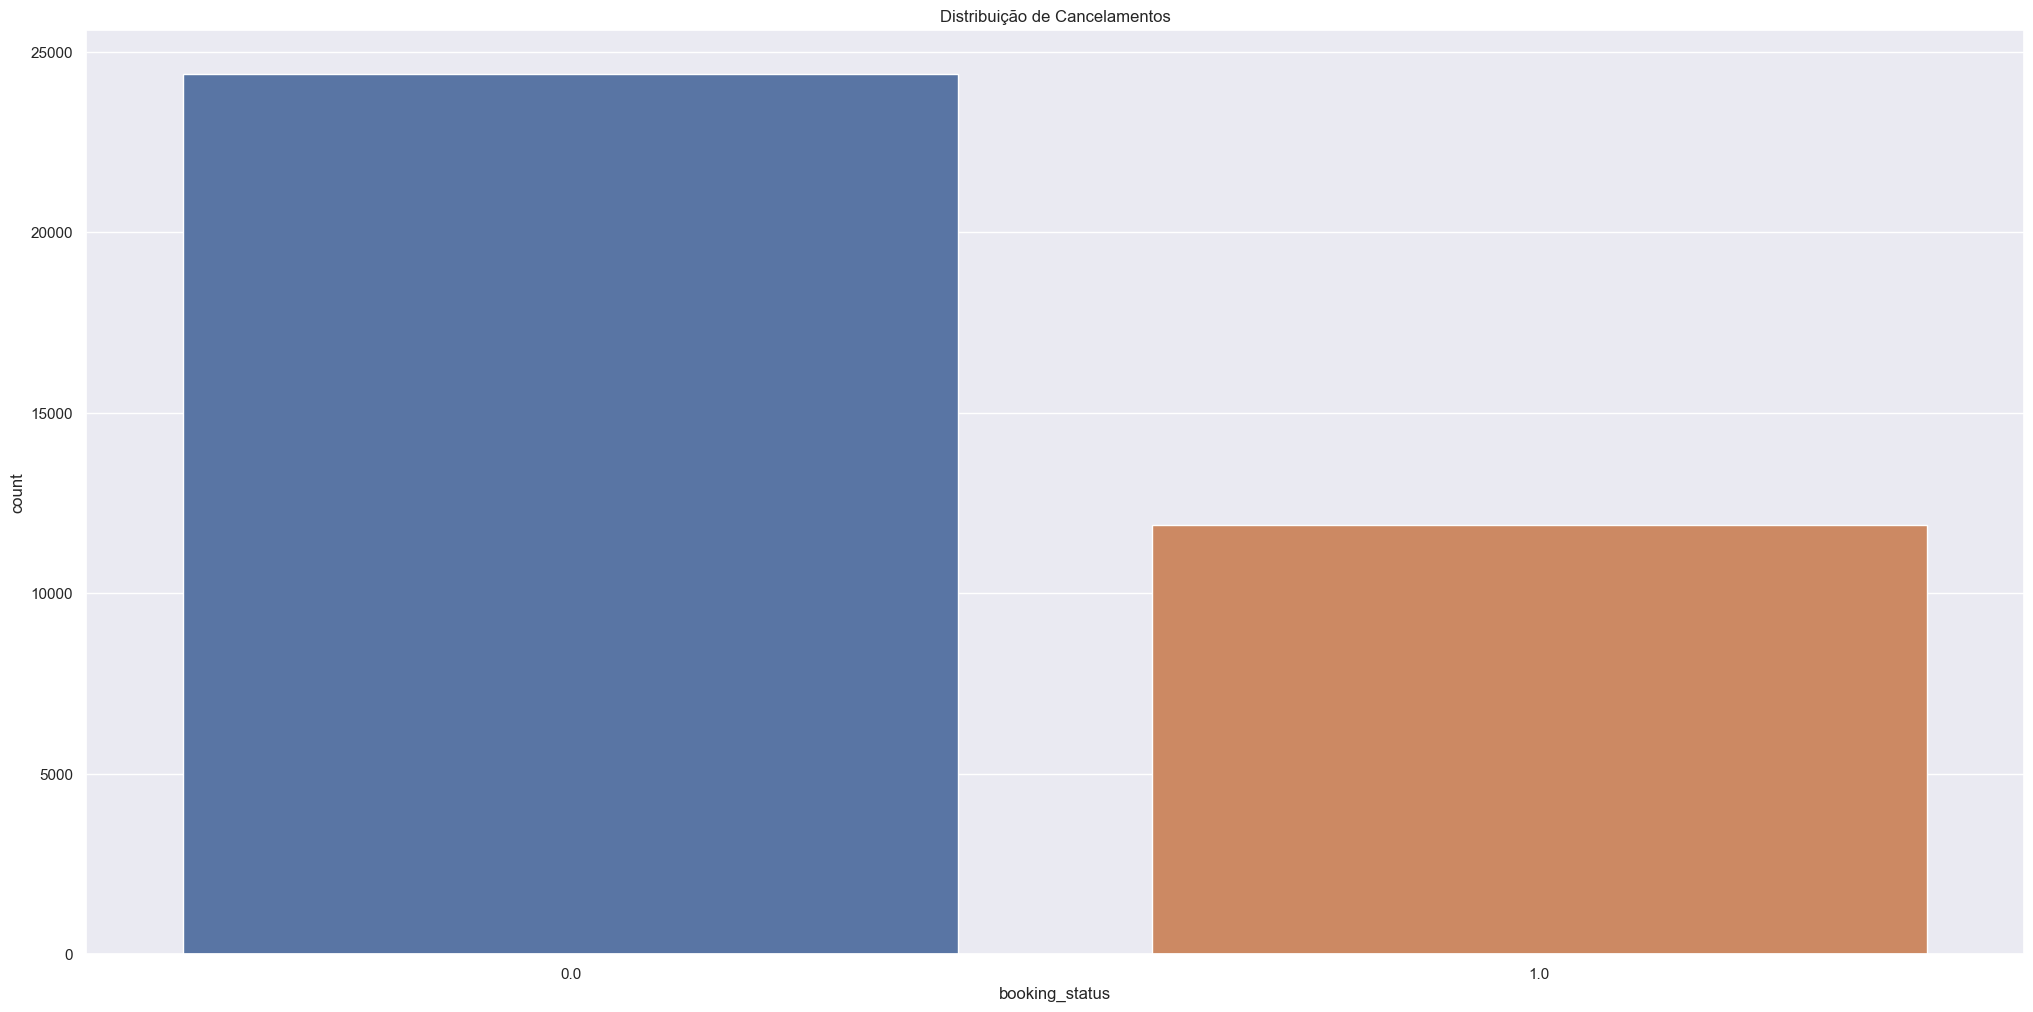

In [89]:
sns.countplot(data=df3, x="booking_status")
plt.title("Distribuição de Cancelamentos")
plt.show()

Note: Data is imbalanced

### 3.1.2 Variáveis Numéricas

In [90]:
num_attributes2 = df3.select_dtypes(exclude=['category','object'])

array([[<Axes: title={'center': 'no_of_adults'}>,
        <Axes: title={'center': 'no_of_children'}>,
        <Axes: title={'center': 'no_of_weekend_nights'}>,
        <Axes: title={'center': 'no_of_week_nights'}>,
        <Axes: title={'center': 'required_car_parking_space'}>],
       [<Axes: title={'center': 'lead_time'}>,
        <Axes: title={'center': 'arrival_year'}>,
        <Axes: title={'center': 'arrival_month'}>,
        <Axes: title={'center': 'arrival_date'}>,
        <Axes: title={'center': 'repeated_guest'}>],
       [<Axes: title={'center': 'no_of_previous_cancellations'}>,
        <Axes: title={'center': 'no_of_previous_bookings_not_canceled'}>,
        <Axes: title={'center': 'avg_price_per_room'}>,
        <Axes: title={'center': 'no_of_special_requests'}>,
        <Axes: title={'center': 'booking_status'}>],
       [<Axes: title={'center': 'total_nights'}>,
        <Axes: title={'center': 'total_guests'}>,
        <Axes: title={'center': 'is_group_booking'}>,
      

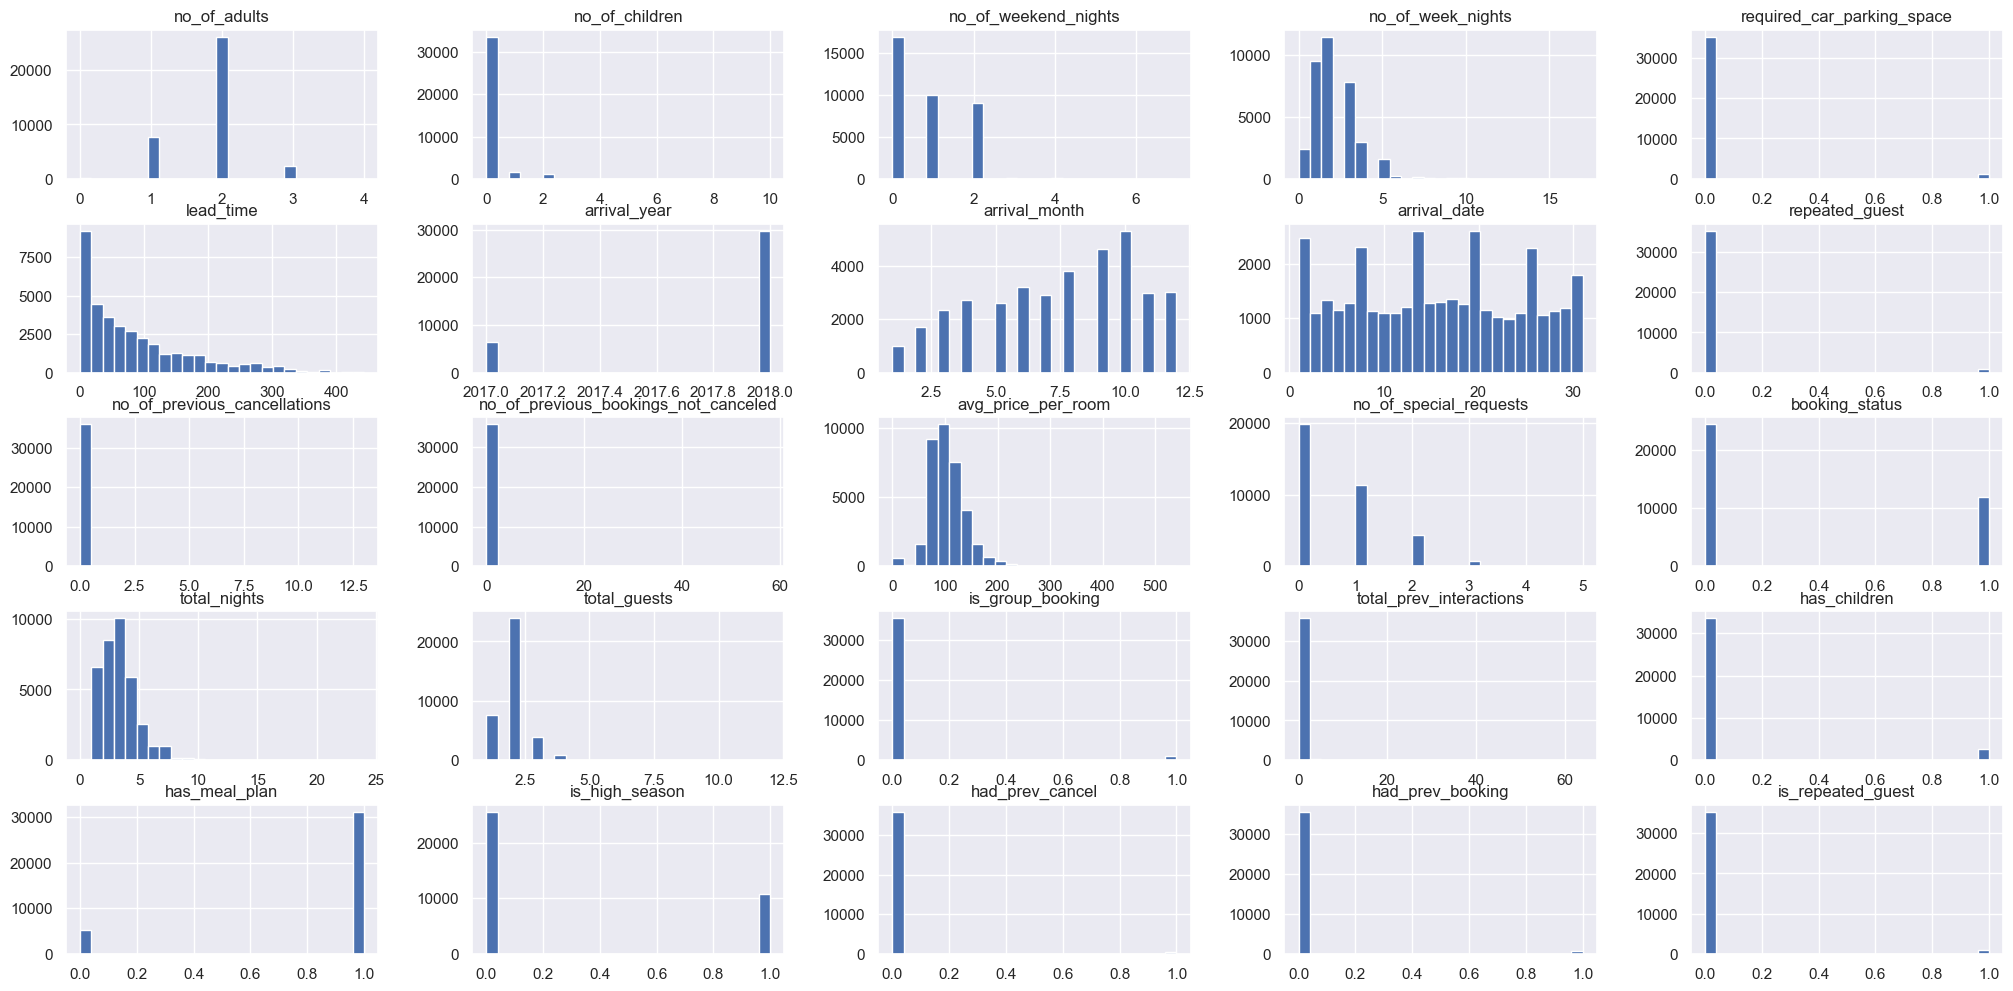

In [91]:
num_attributes2.hist(bins=25)

### 3.1.2 Variáveis Categóricas

In [92]:
cat_attributes2 = df3.select_dtypes(include=['category','object'])

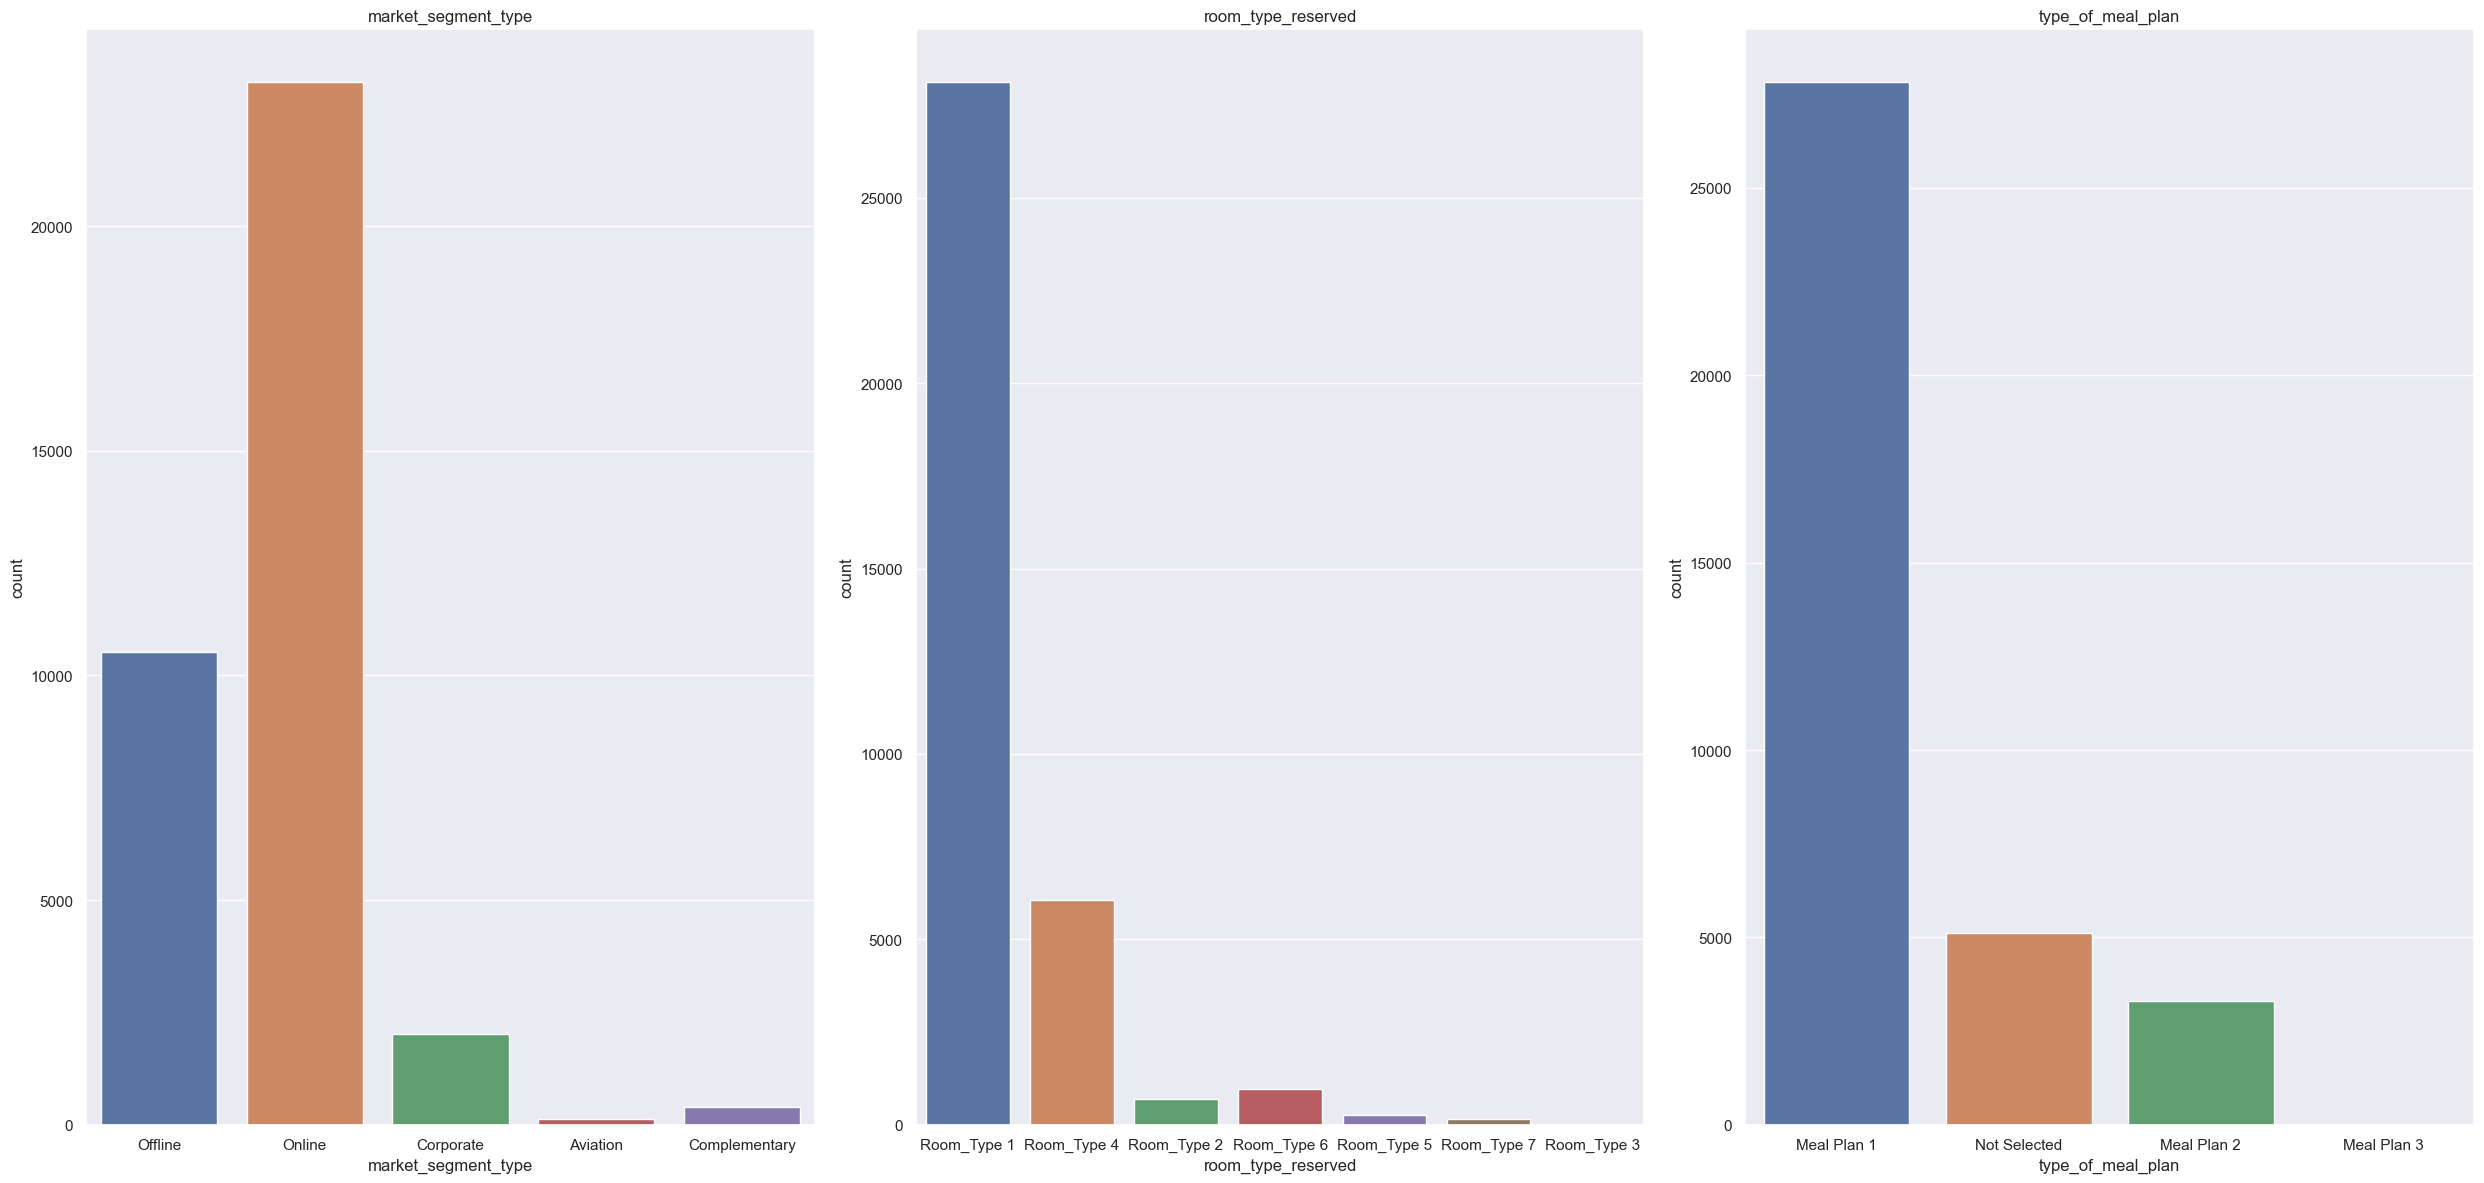

In [93]:
plt.subplot(1, 3, 1)
sns.countplot(x='market_segment_type', data=cat_attributes2)
plt.title("market_segment_type")

plt.subplot(1, 3, 2)
sns.countplot(x='room_type_reserved', data=cat_attributes2)
plt.title("room_type_reserved")

plt.subplot(1, 3, 3)
sns.countplot(x='type_of_meal_plan', data=cat_attributes2)
plt.title("type_of_meal_plan")

plt.tight_layout()
plt.show()


## 3.2 Analise Bivariada

### 3.2.1 Hipóteses do Cliente

Reservas com maior número total de hóspedes (adultos + crianças) têm maior chance de cancelamento.

Text(0.5, 1.0, 'H1/H2 - Total de hóspedes vs Cancelamento')

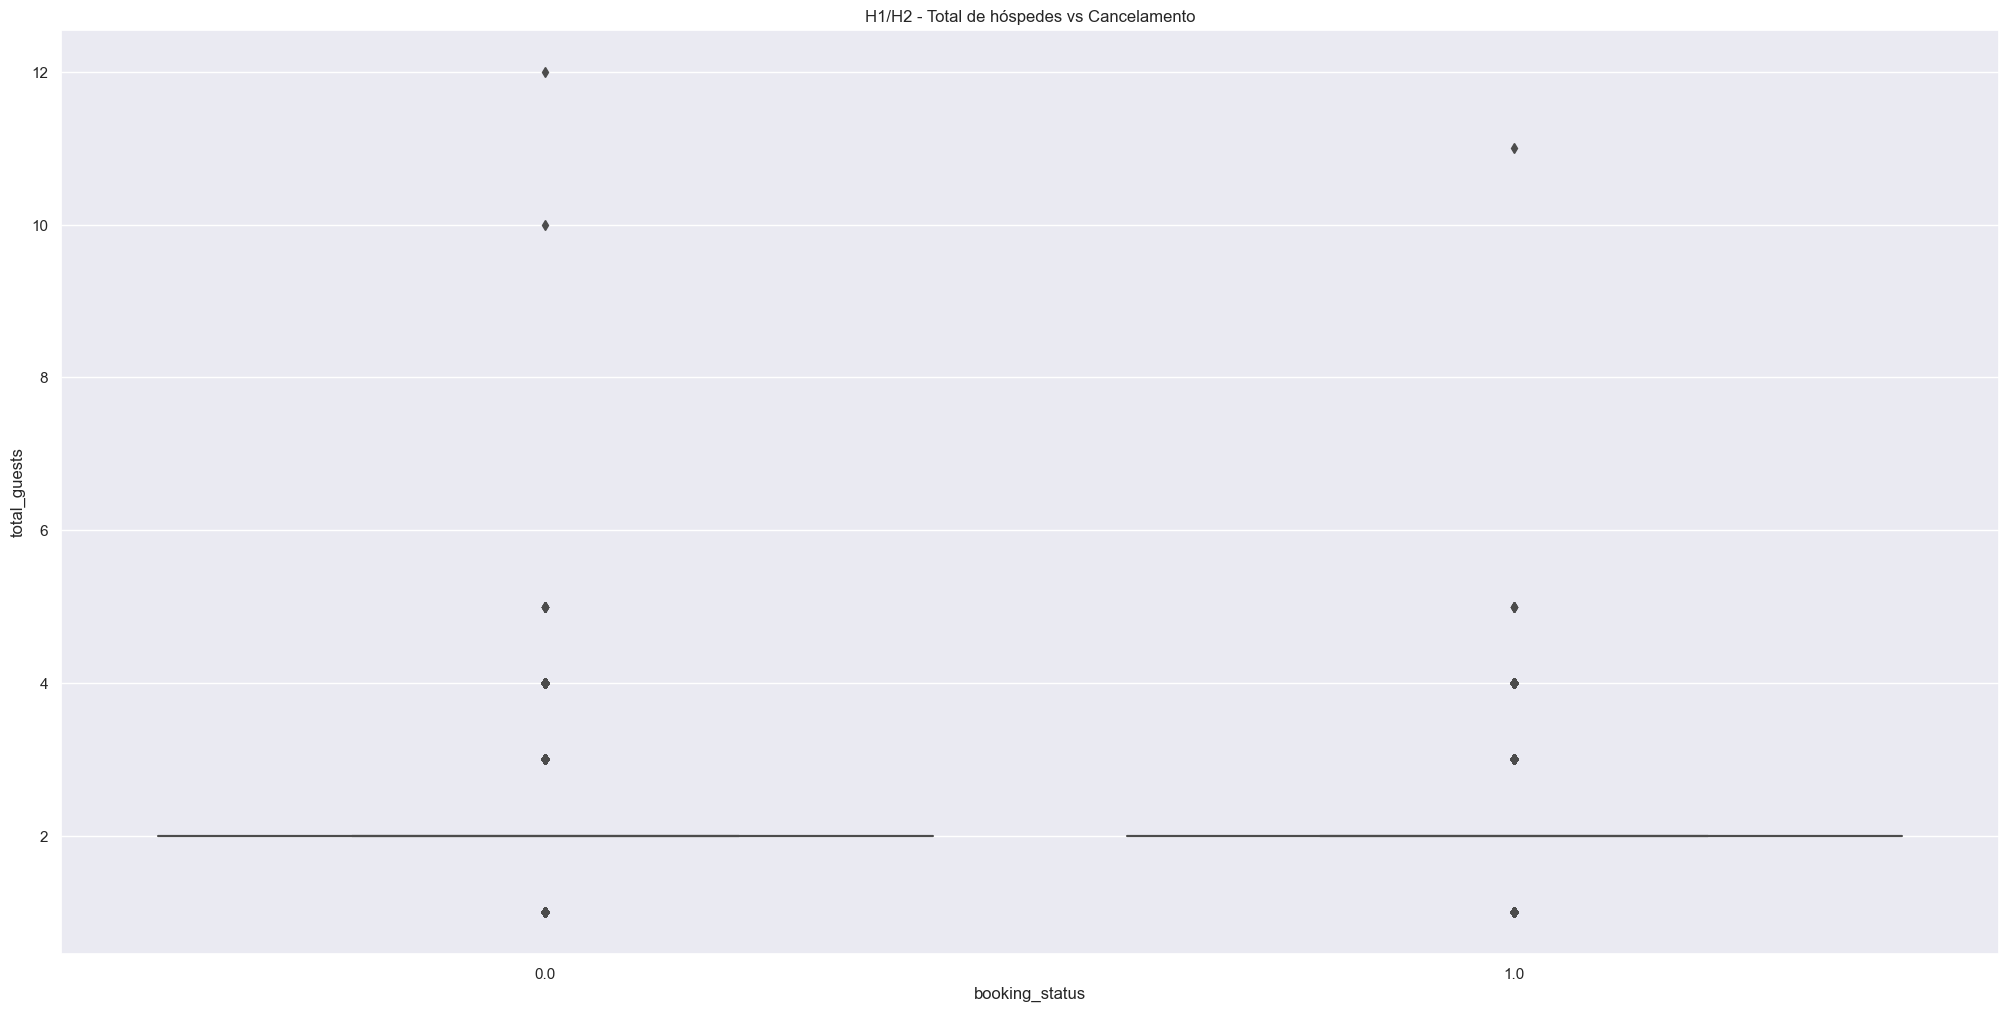

In [94]:
sns.boxplot(x="booking_status", y="total_guests", data=df3)
plt.title("H1/H2 - Total de hóspedes vs Cancelamento")

Reservas com crianças são mais suscetíveis a cancelamentos

Text(0.5, 1.0, 'Presença de crianças vs Cancelamento')

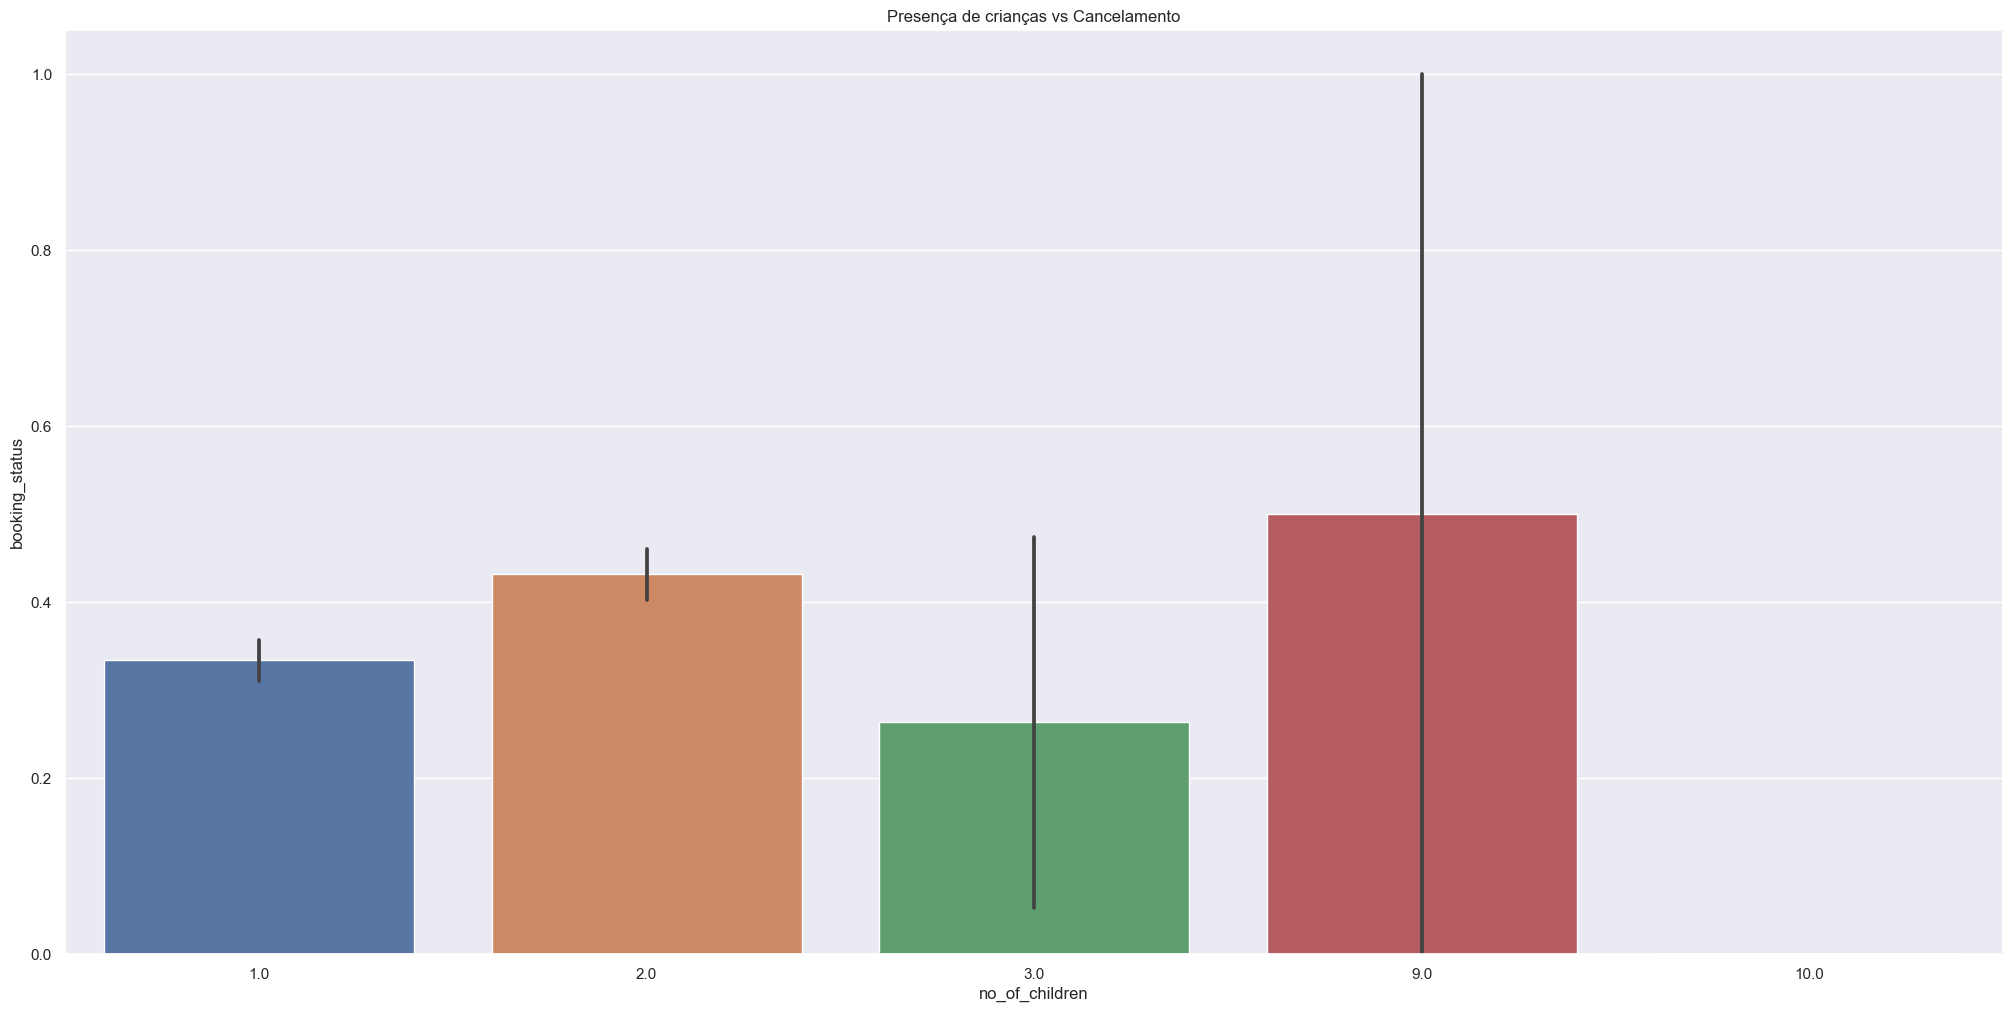

In [95]:
sns.barplot(x="no_of_children", y="booking_status", data=df3.loc[df3['no_of_children'] > 0])
plt.title("Presença de crianças vs Cancelamento")

Hóspedes repetidos têm menor probabilidade de cancelar (maior fidelização)

Text(0.5, 1.0, 'Hóspede repetido vs Cancelamento')

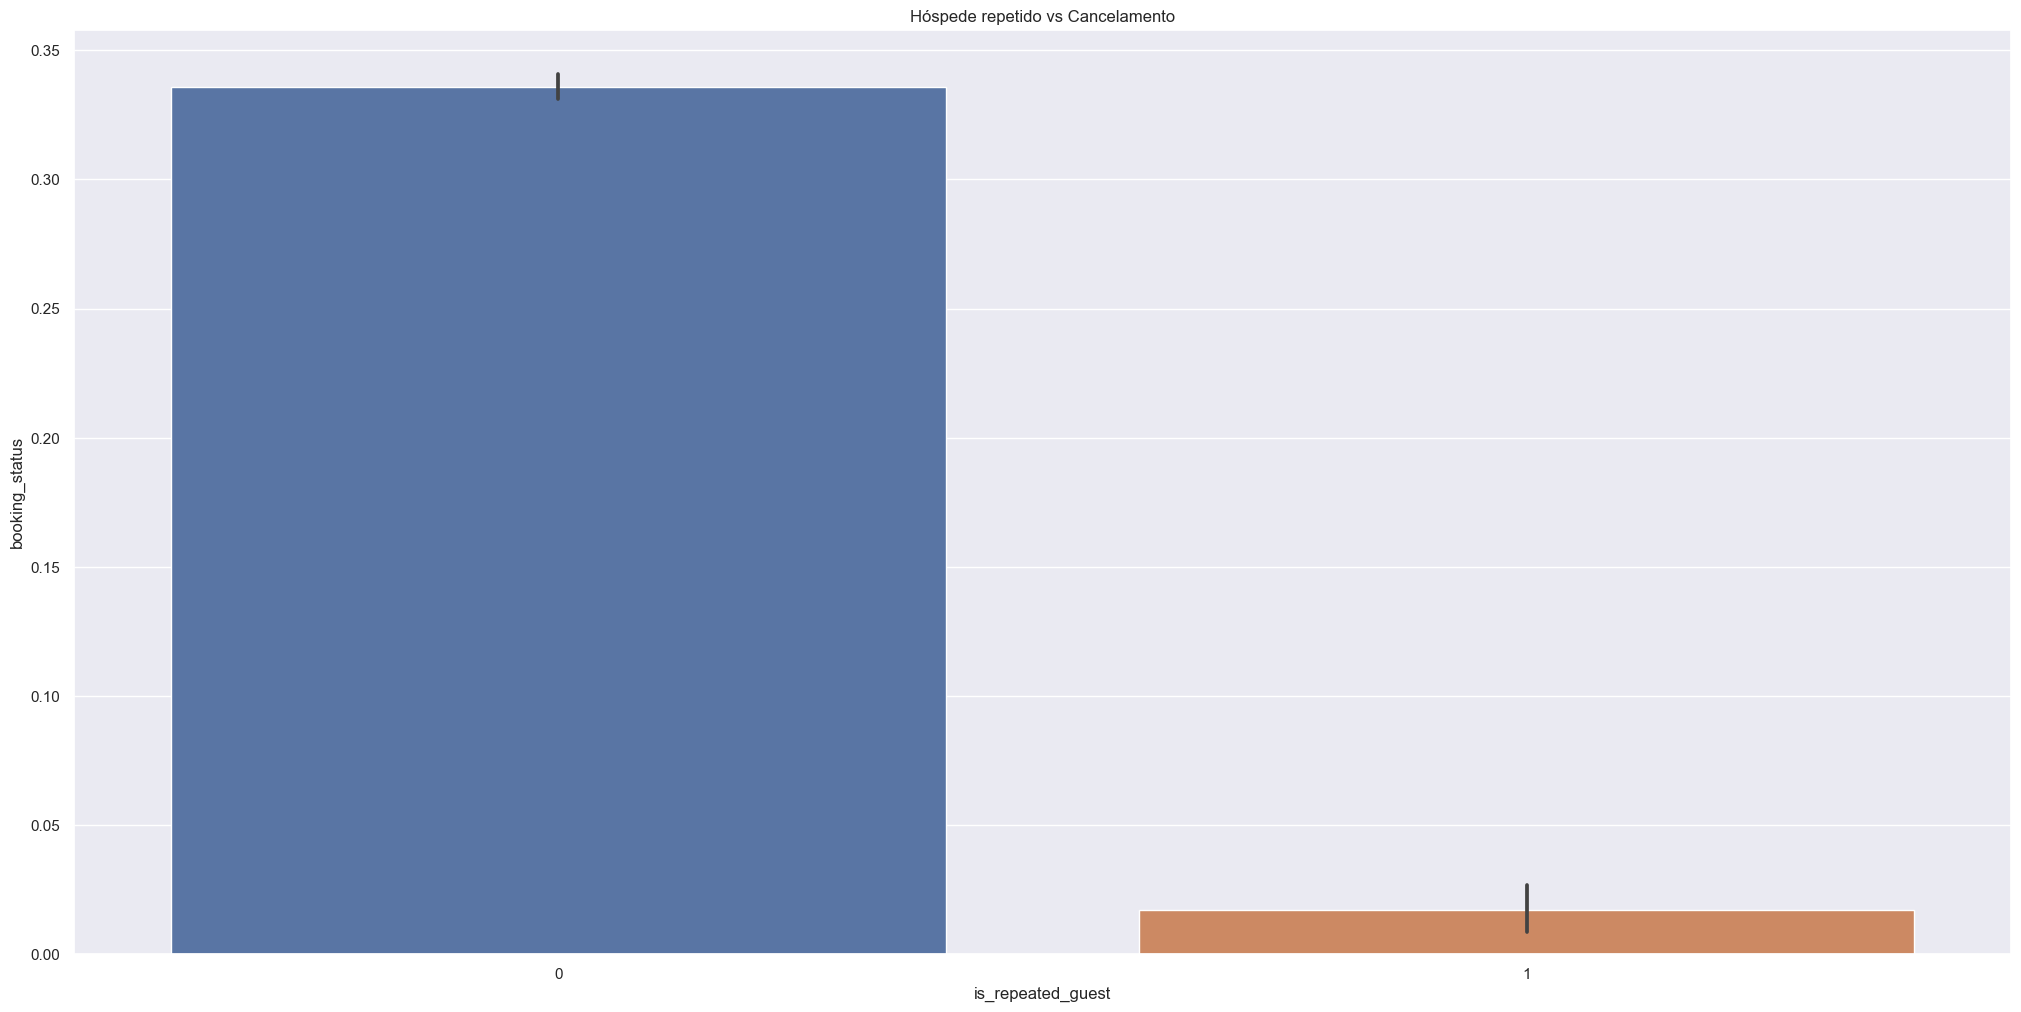

In [96]:
sns.barplot(x="is_repeated_guest", y="booking_status", data=df3)
plt.title("Hóspede repetido vs Cancelamento")

Hóspedes com reservas anteriores não canceladas tendem a manter novas reservas.

Text(0.5, 1.0, 'Histórico de reservas mantidas vs Cancelamento')

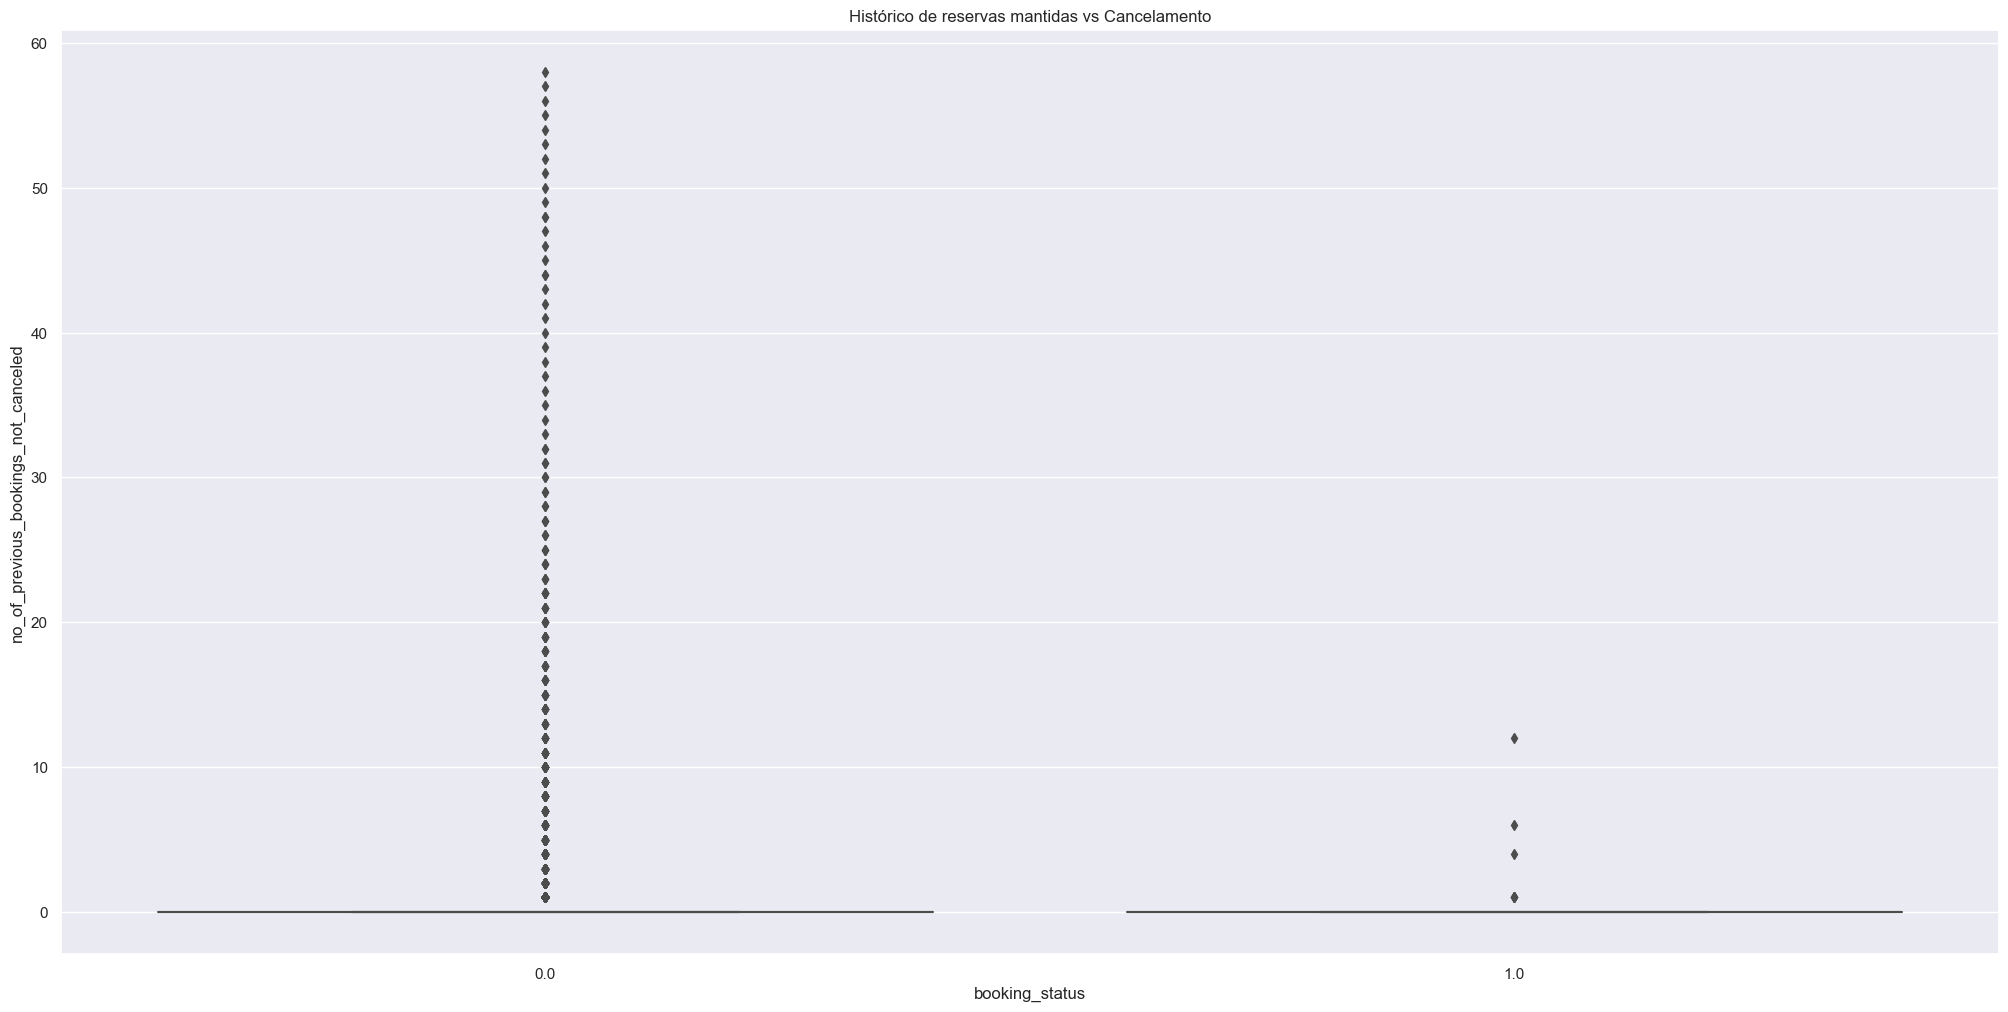

In [97]:
sns.boxplot(x="booking_status", y="no_of_previous_bookings_not_canceled", data=df3)
plt.title("Histórico de reservas mantidas vs Cancelamento")

Reservas feitas com alta antecedência (>90 dias) têm maior probabilidade de cancelamento.

Reservas de última hora (<7 dias) são mais confiáveis (menor taxa de cancelamento).

Uma diferença longa entre data de reserva e data de chegada (lead_time) está associada a mais cancelamentos.

Text(0.5, 1.0, 'Lead time vs Cancelamento')

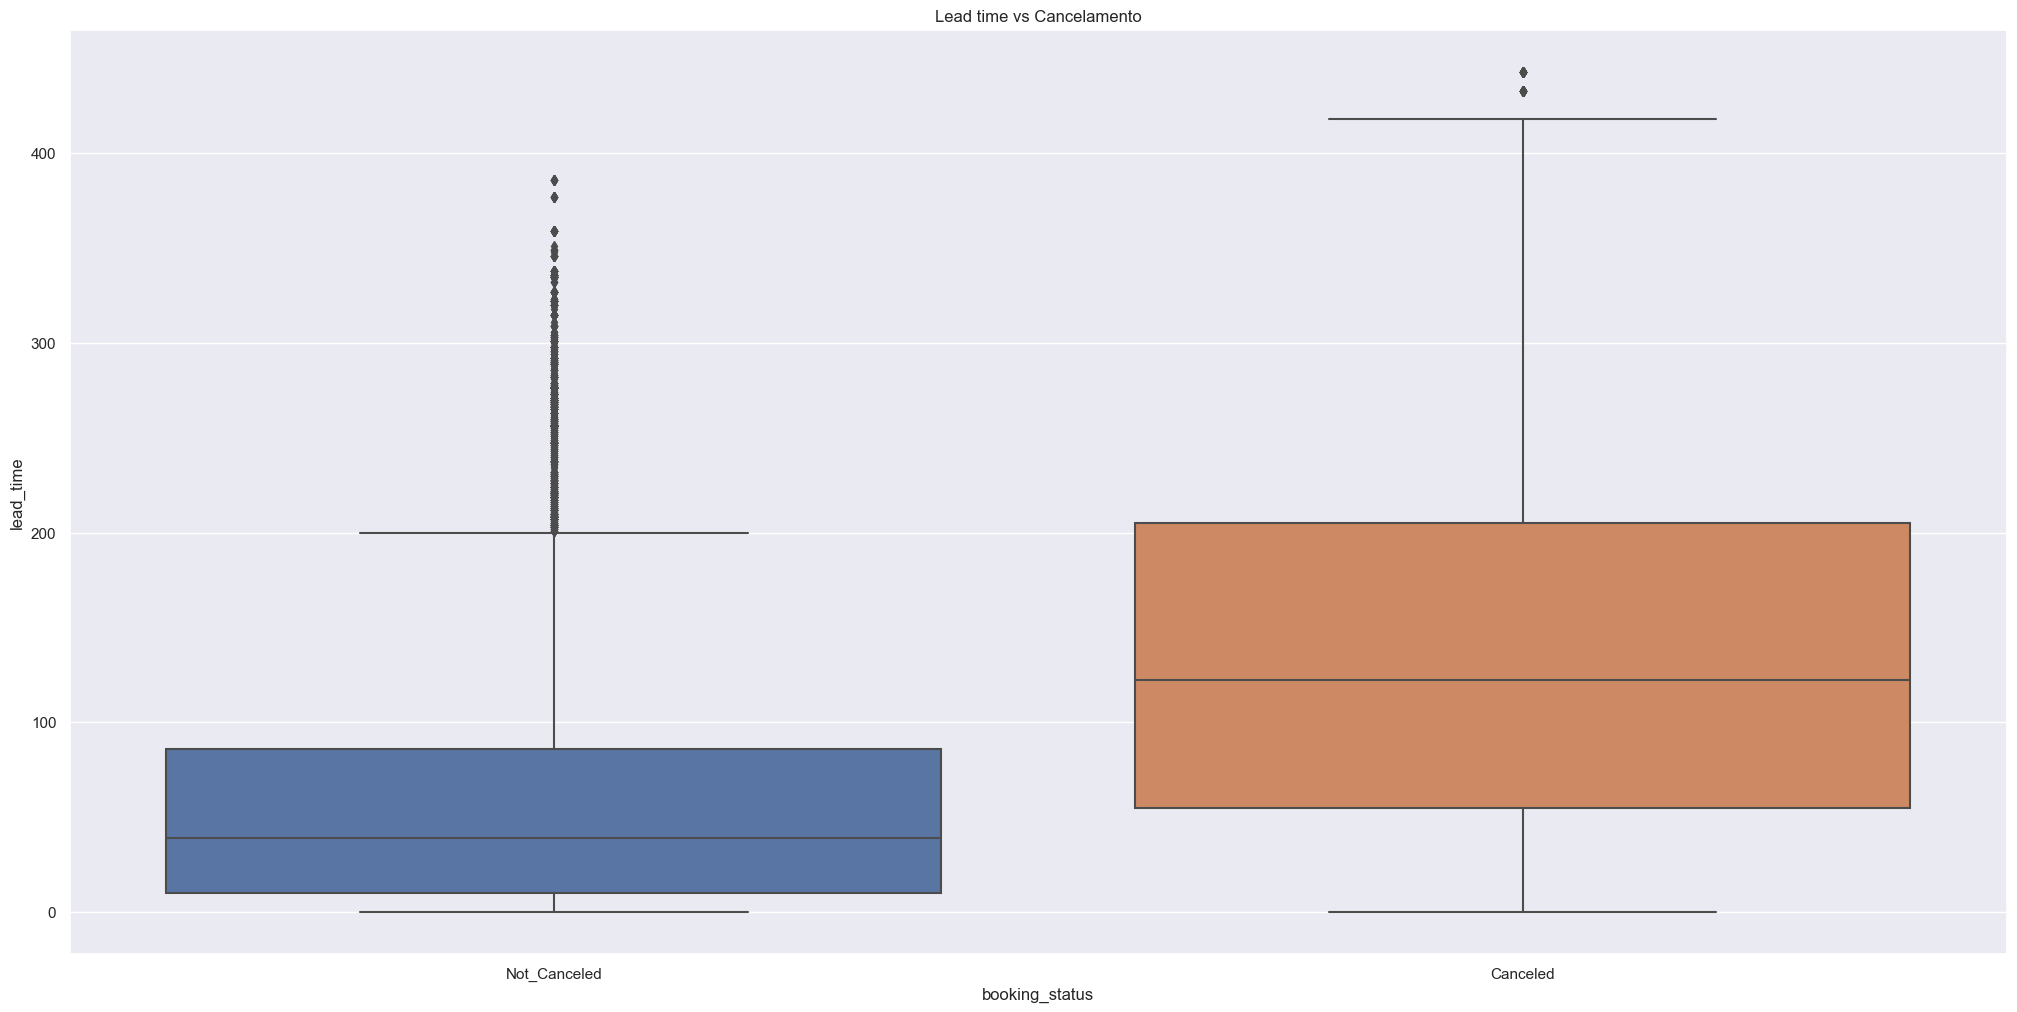

In [98]:
sns.boxplot(x="booking_status", y="lead_time", data=df)
plt.title("Lead time vs Cancelamento")

Reservas com estadia apenas em fim de semana têm mais risco de cancelamento.

Text(0.5, 1.0, 'Noites de fim de semana vs Cancelamento')

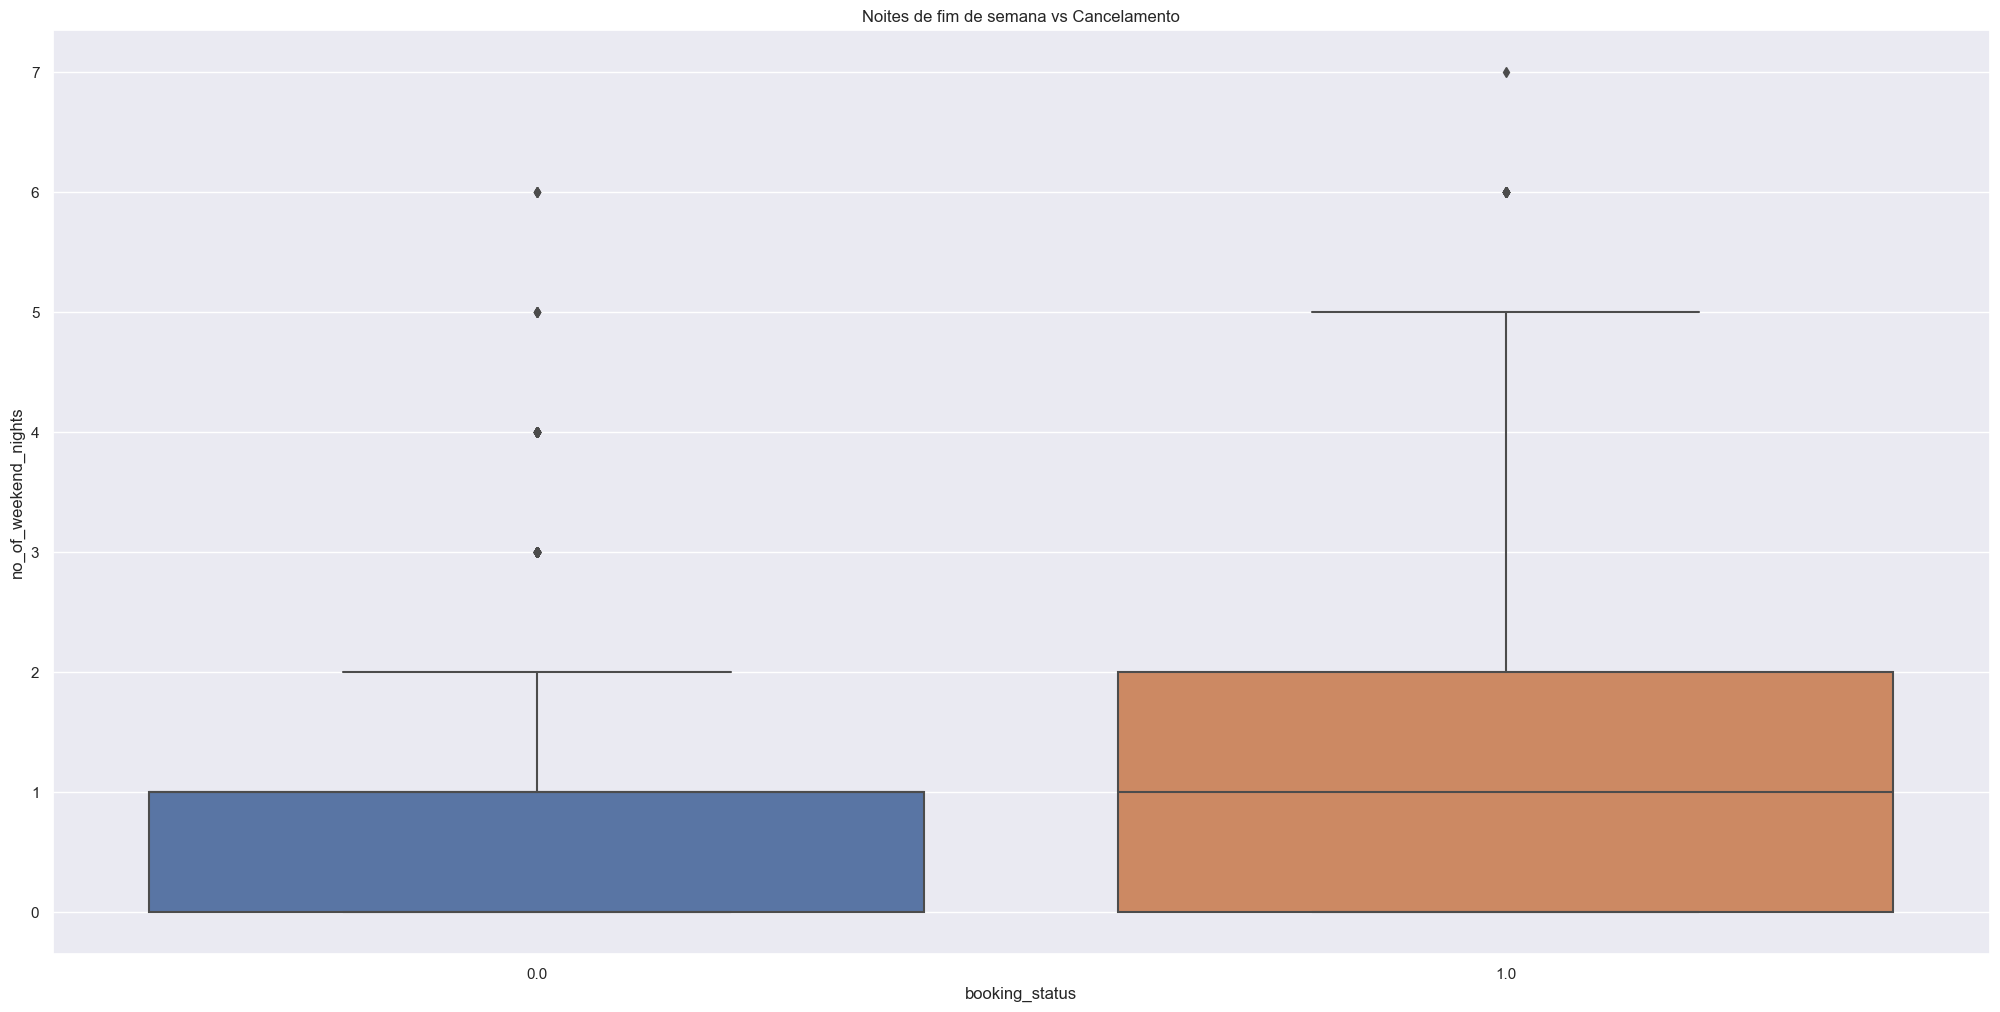

In [99]:
sns.boxplot(x="booking_status", y="no_of_weekend_nights", data=df3)
plt.title("Noites de fim de semana vs Cancelamento")

Reservas com alto valor médio por quarto são menos propensas a cancelamento.

Text(0.5, 1.0, 'Preço médio por quarto vs Cancelamento')

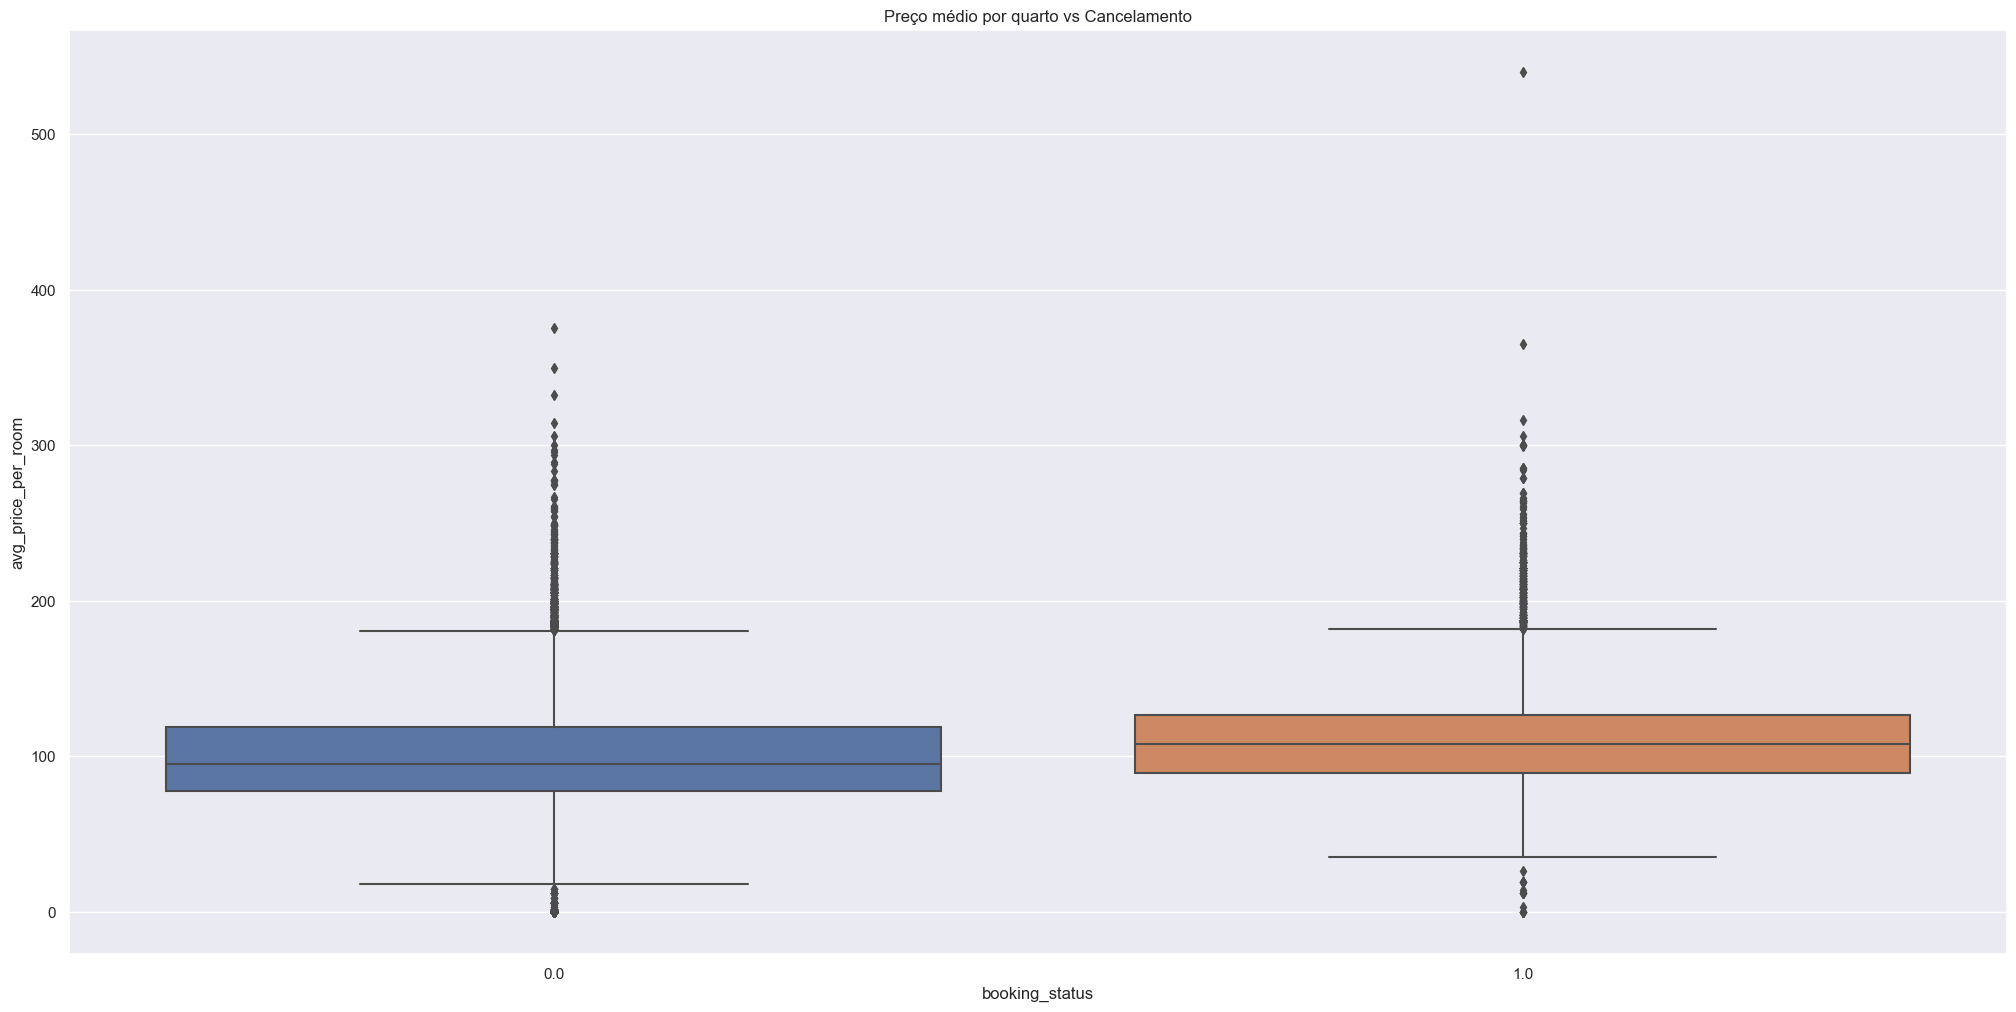

In [100]:
sns.boxplot(x="booking_status", y="avg_price_per_room", data=df3)
plt.title("Preço médio por quarto vs Cancelamento")

Reservas feitas para alta temporada têm menor taxa de cancelamento.

Text(0.5, 1.0, 'Alta temporada vs Cancelamento')

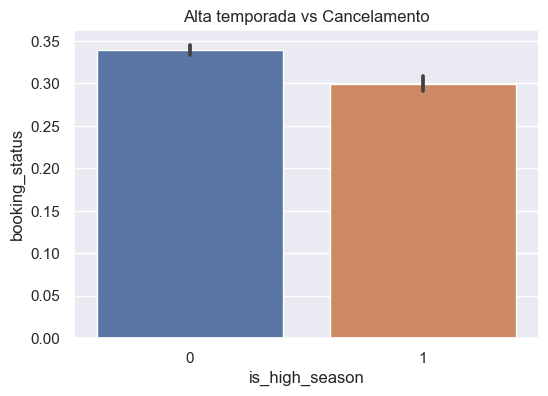

In [101]:
df3["is_high_season"] = df3["arrival_month"].isin([1, 7, 8, 12]).astype(int)
plt.figure(figsize=(6, 4))
sns.barplot(x="is_high_season", y="booking_status", data=df3)
plt.title("Alta temporada vs Cancelamento")

Reservas do segmento “Online” têm maior taxa de cancelamento do que “Corporate” ou “Offline”.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Offline'),
  Text(1, 0, 'Online'),
  Text(2, 0, 'Corporate'),
  Text(3, 0, 'Aviation'),
  Text(4, 0, 'Complementary')])

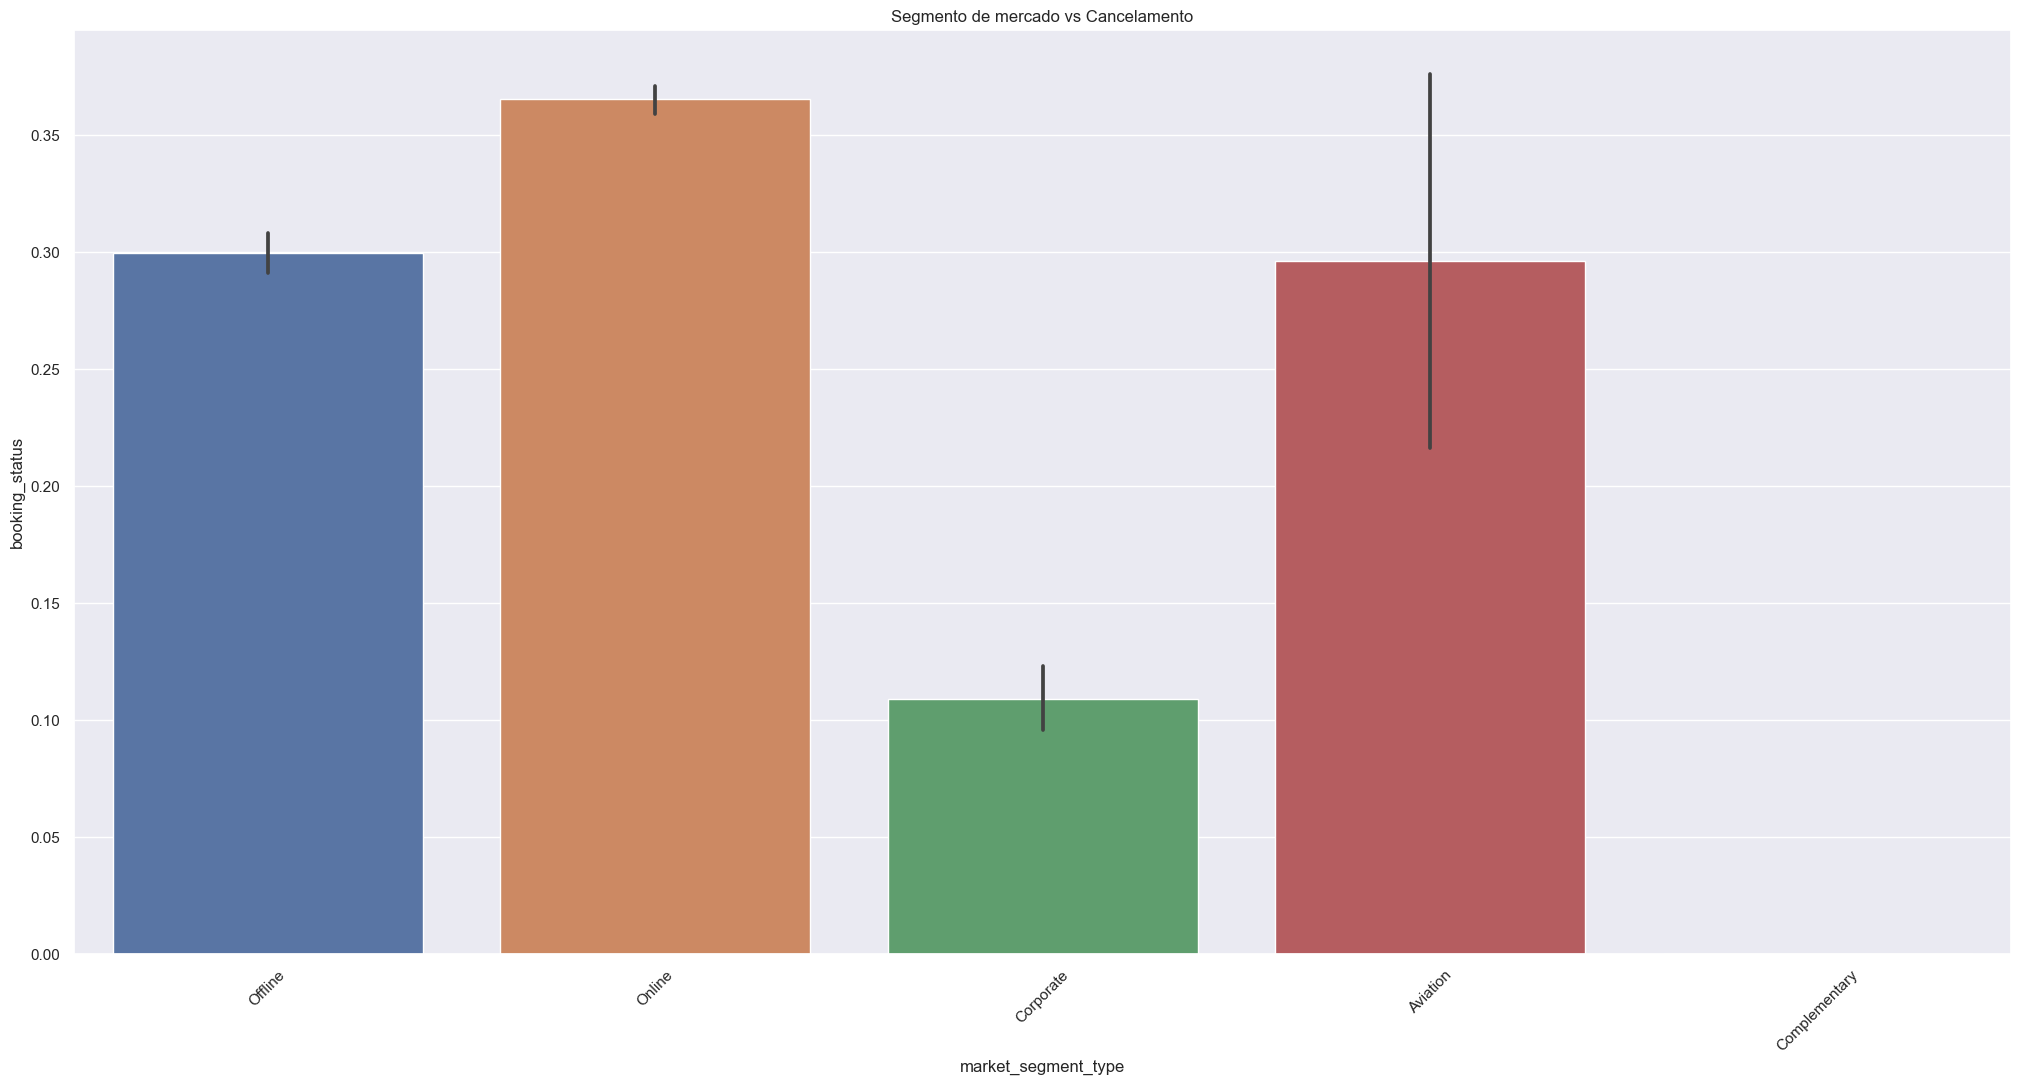

In [102]:
sns.barplot(x="market_segment_type", y="booking_status", data=df3)
plt.title("Segmento de mercado vs Cancelamento")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'H10 - Fins de semana reservados vs Cancelamento')

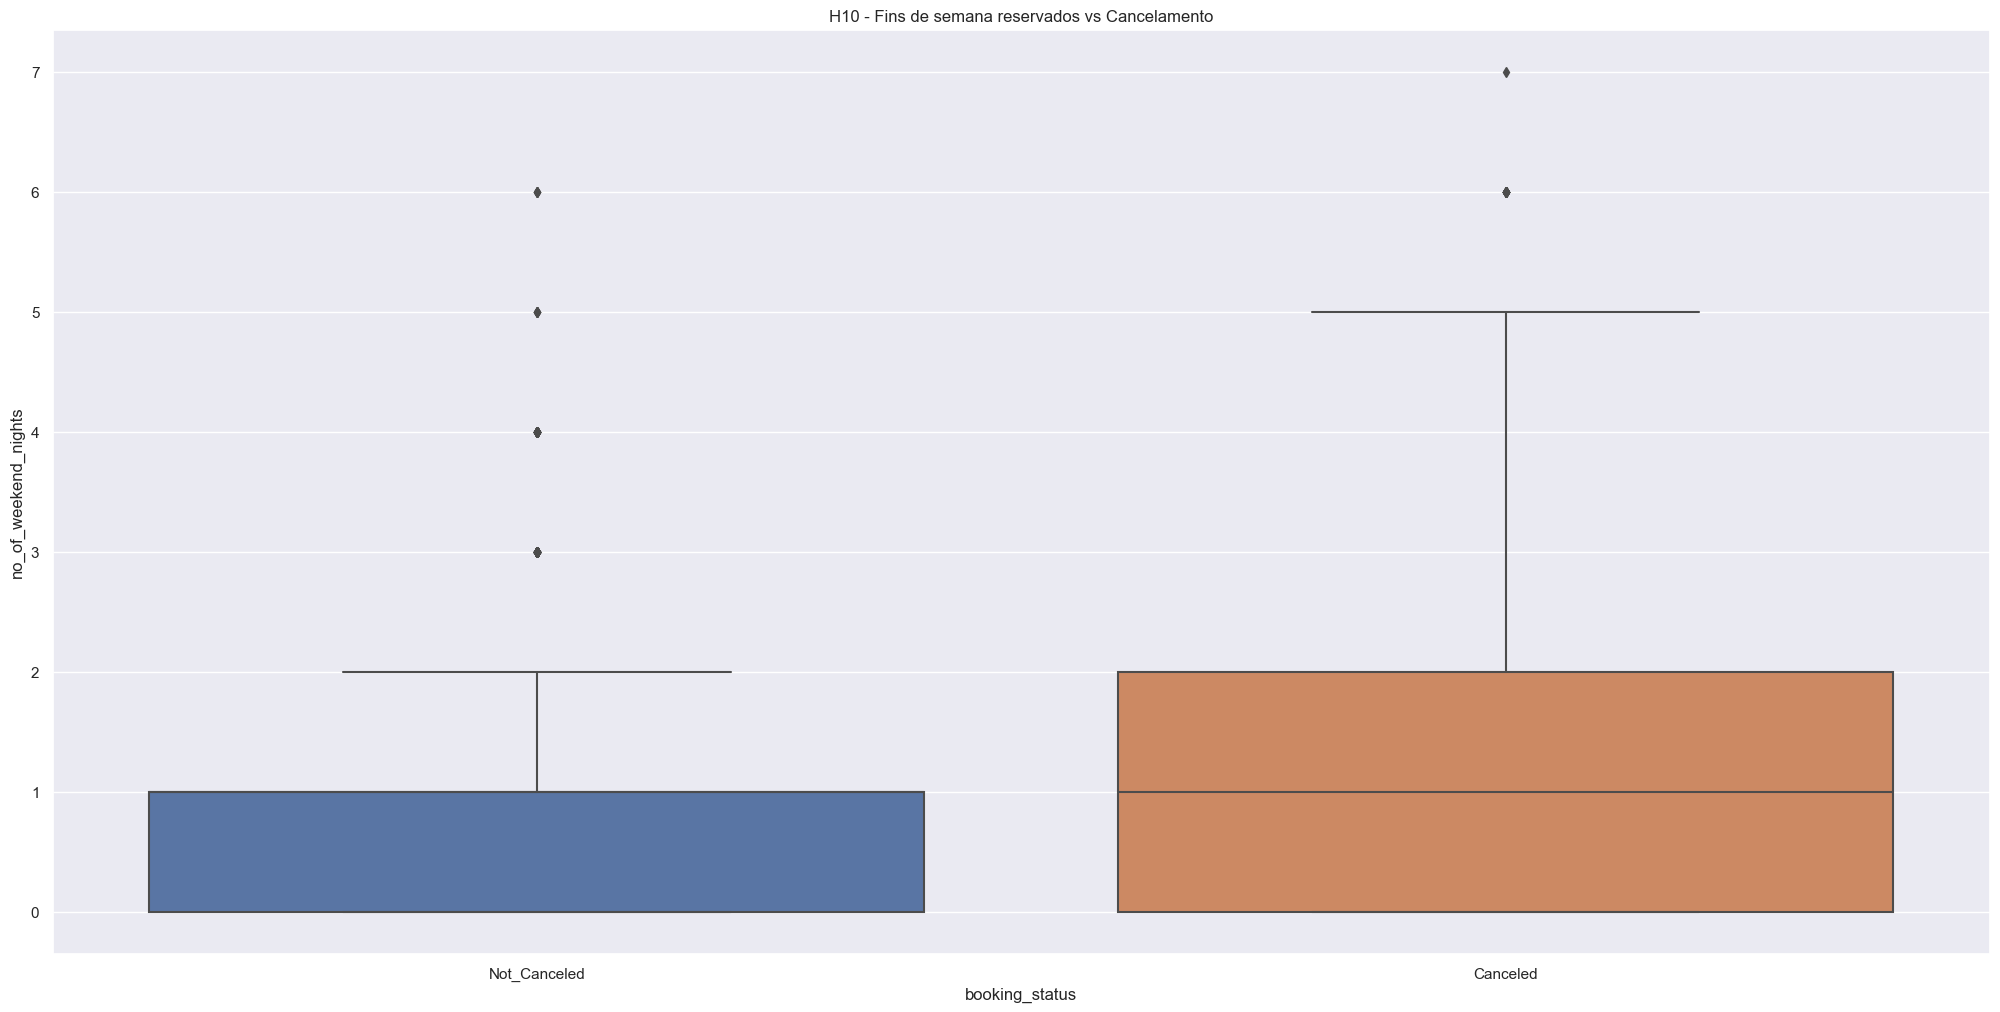

In [103]:
sns.boxplot(x="booking_status", y="no_of_weekend_nights", data=df)
plt.title("H10 - Fins de semana reservados vs Cancelamento")

Text(0.5, 1.0, 'H13 - Estacionamento requerido vs Cancelamento')

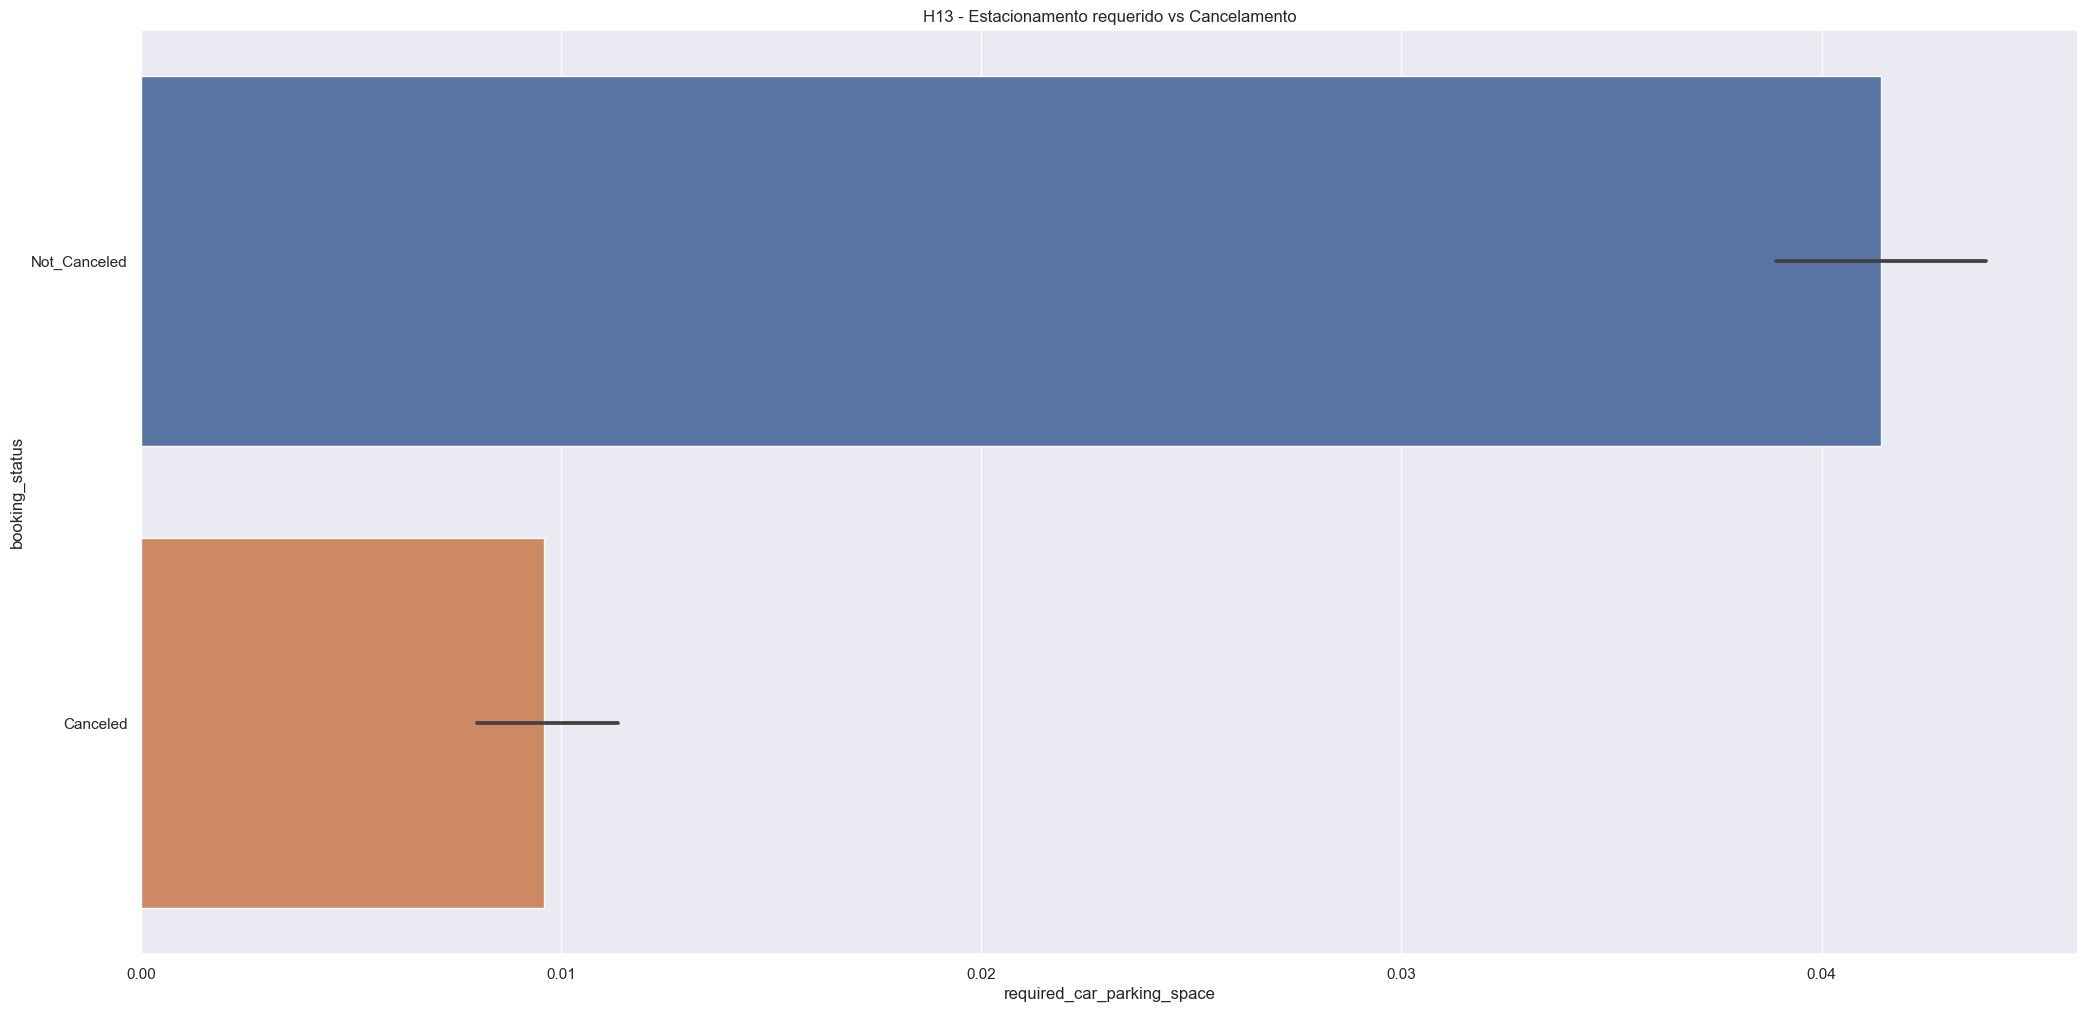

In [104]:
sns.barplot(x="required_car_parking_space", y="booking_status", data=df)
plt.title("H13 - Estacionamento requerido vs Cancelamento")

## 3.3 Analise Multivariada

### 3.3.1 Atributos Numéricos

In [105]:
num_attributes3 = df3.select_dtypes(exclude=['object', 'category'])
num_attributes3 = num_attributes3.drop('booking_status', axis=1)
num_attributes3

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest
0,2.0,0.0,1.0,2.0,0.0,224.0,2017.0,10.0,2.0,0.0,0.0,0.0,65.00,0.0,3.0,2.0,0,0.0,0,1,0,0,0,0
1,2.0,0.0,2.0,3.0,0.0,5.0,2018.0,11.0,6.0,0.0,0.0,0.0,106.68,1.0,5.0,2.0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,2018.0,2.0,28.0,0.0,0.0,0.0,60.00,0.0,3.0,1.0,0,0.0,0,1,0,0,0,0
3,2.0,0.0,0.0,2.0,0.0,211.0,2018.0,5.0,20.0,0.0,0.0,0.0,100.00,0.0,2.0,2.0,0,0.0,0,1,0,0,0,0
4,2.0,0.0,1.0,1.0,0.0,48.0,2018.0,4.0,11.0,0.0,0.0,0.0,94.50,0.0,2.0,2.0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3.0,0.0,2.0,6.0,0.0,85.0,2018.0,8.0,3.0,0.0,0.0,0.0,167.80,1.0,8.0,3.0,0,0.0,0,1,1,0,0,0
36271,2.0,0.0,1.0,3.0,0.0,228.0,2018.0,10.0,17.0,0.0,0.0,0.0,90.95,2.0,4.0,2.0,0,0.0,0,1,0,0,0,0
36272,2.0,0.0,2.0,6.0,0.0,148.0,2018.0,7.0,1.0,0.0,0.0,0.0,98.39,2.0,8.0,2.0,0,0.0,0,1,1,0,0,0
36273,2.0,0.0,0.0,3.0,0.0,63.0,2018.0,4.0,21.0,0.0,0.0,0.0,94.50,0.0,3.0,2.0,0,0.0,0,0,0,0,0,0


In [106]:
correlation = num_attributes3.corr(method='pearson')

<Axes: >

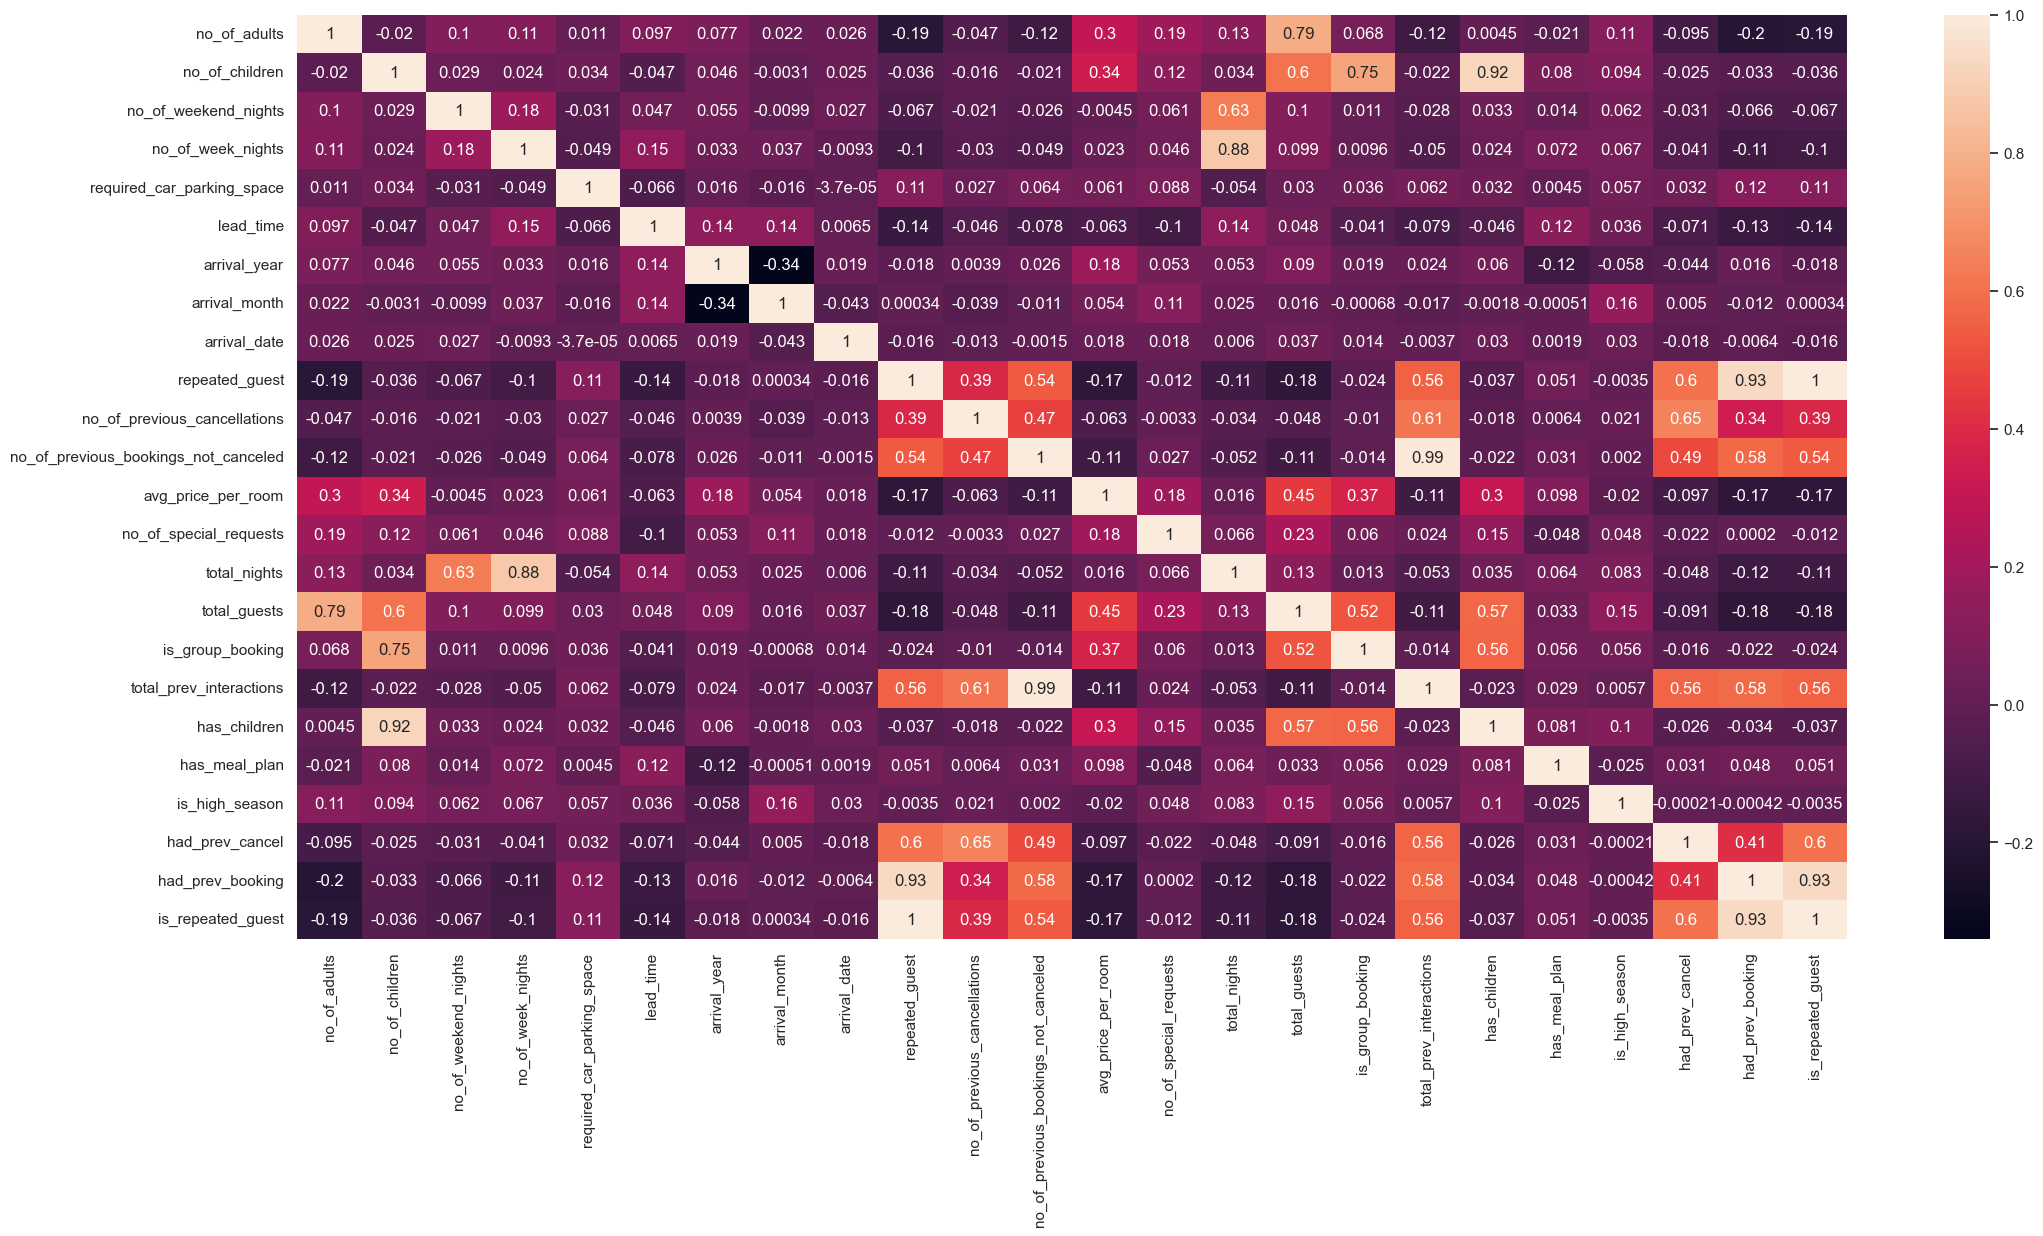

In [107]:
plt.figure(figsize=(25,12))
sns.heatmap(correlation, annot=True)

As variáveis numéricas em geral não apresentam multicolinearidade forte.

In [108]:
# Converter booking_status para binário: 1 = Canceled, 0 = Not_Canceled
df['booking_canceled'] = df['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Correlação entre variáveis numéricas e cancelamento
correlation = df.corr(numeric_only=True)['booking_canceled'].sort_values(ascending=False)

# Exibir correlação com variável alvo
correlation


booking_canceled                        1.000000
lead_time                               0.438538
arrival_year                            0.179529
avg_price_per_room                      0.142569
no_of_week_nights                       0.092996
no_of_adults                            0.086920
no_of_weekend_nights                    0.061563
no_of_children                          0.033078
arrival_date                            0.010629
arrival_month                          -0.011233
no_of_previous_cancellations           -0.033728
no_of_previous_bookings_not_canceled   -0.060179
required_car_parking_space             -0.086185
repeated_guest                         -0.107287
no_of_special_requests                 -0.253070
Name: booking_canceled, dtype: float64

🔺 Correlação Positiva (aumenta chance de cancelamento):
lead_time: 0.44 → Quanto maior o tempo de antecedência, maior a chance de cancelamento.

avg_price_per_room: 0.14 → Preços mais altos têm leve tendência a maior cancelamento.

arrival_year: 0.18 → Pode refletir sazonalidade ou mudanças de comportamento ao longo do tempo.

🔻 Correlação Negativa (reduz chance de cancelamento):
no_of_special_requests: -0.25 → Clientes com pedidos especiais tendem a cancelar menos.

repeated_guest: -0.11 → Hóspedes recorrentes têm menor taxa de cancelamento.

required_car_parking_space: -0.09 → Pode ser um sinal de compromisso com a estadia.

### 3.3.1 Atributos Categóricos

100%|██████████| 3/3 [00:00<00:00, 79.16it/s]


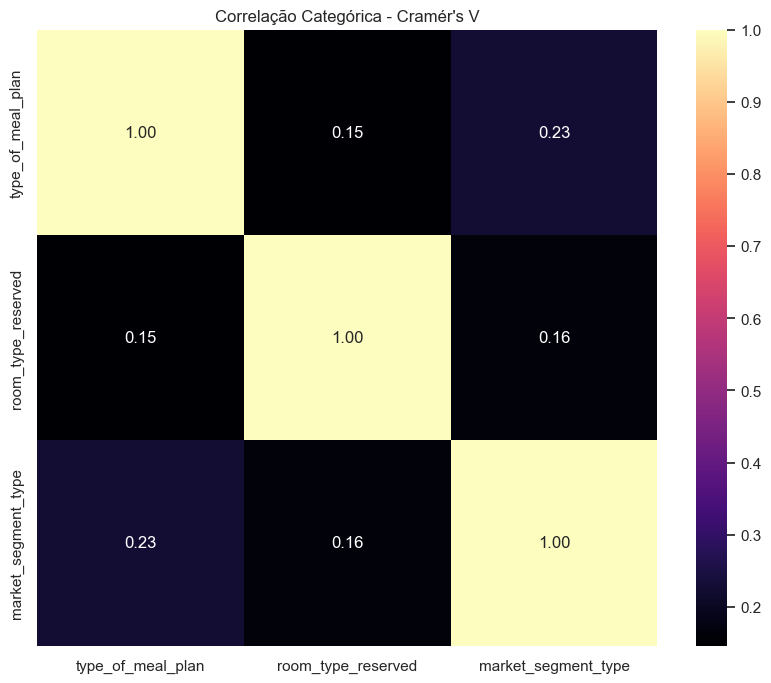

In [109]:
from scipy.stats import chi2_contingency
from tqdm import tqdm
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Selecionar colunas categóricas com poucos níveis
cat_cols = df3.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if df3[col].nunique() <= 20]

# Criar matriz vazia
cramer_v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

# Preencher a matriz com tqdm para visualizar progresso
for i, col1 in tqdm(enumerate(cat_cols), total=len(cat_cols)):
    for j, col2 in enumerate(cat_cols[i:], i):
        if col1 == col2:
            cramer_v_matrix.loc[col1, col2] = 1.0
        else:
            v = cramers_v(df3[col1], df3[col2])
            cramer_v_matrix.loc[col1, col2] = v
            cramer_v_matrix.loc[col2, col1] = v

# Converter valores para float
cramer_v_matrix = cramer_v_matrix.astype(float)

# Plotar mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlação Categórica - Cramér's V")
plt.show()

# 4.0 Modelagem de dados

In [110]:
df4 = df3.copy()

## 4.1 Scaling

In [111]:
df4.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest
0,2.0,0.0,1.0,2.0,0.0,224.0,2017.0,10.0,2.0,0.0,0.0,0.0,65.00,0.0,0.0,INN00001,Meal Plan 1,Room_Type 1,Offline,3.0,2.0,0,0.0,0,1,0,0,0,0
1,2.0,0.0,2.0,3.0,0.0,5.0,2018.0,11.0,6.0,0.0,0.0,0.0,106.68,1.0,0.0,INN00002,Not Selected,Room_Type 1,Online,5.0,2.0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,2018.0,2.0,28.0,0.0,0.0,0.0,60.00,0.0,1.0,INN00003,Meal Plan 1,Room_Type 1,Online,3.0,1.0,0,0.0,0,1,0,0,0,0
3,2.0,0.0,0.0,2.0,0.0,211.0,2018.0,5.0,20.0,0.0,0.0,0.0,100.00,0.0,1.0,INN00004,Meal Plan 1,Room_Type 1,Online,2.0,2.0,0,0.0,0,1,0,0,0,0
4,2.0,0.0,1.0,1.0,0.0,48.0,2018.0,4.0,11.0,0.0,0.0,0.0,94.50,0.0,1.0,INN00005,Not Selected,Room_Type 1,Online,2.0,2.0,0,0.0,0,0,0,0,0,0


In [160]:
# Selecionar colunas numéricas contínuas (exceto variáveis binárias e categóricas codificadas)
numeric_features = [
    'lead_time', 'no_of_adults', 'no_of_children',
    'no_of_week_nights', 'no_of_weekend_nights',
    'avg_price_per_room', 'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled', 'no_of_special_requests'
]

scaler = StandardScaler()
scaler.fit(df[numeric_features])
pickle.dump(scaler, open('parameter/hotelsmart_scaler.pkl', 'wb'))

## 4.3 Encoding

In [113]:
df4.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest
0,2.0,0.0,1.0,2.0,0.0,224.0,2017.0,10.0,2.0,0.0,0.0,0.0,65.00,0.0,0.0,INN00001,Meal Plan 1,Room_Type 1,Offline,3.0,2.0,0,0.0,0,1,0,0,0,0
1,2.0,0.0,2.0,3.0,0.0,5.0,2018.0,11.0,6.0,0.0,0.0,0.0,106.68,1.0,0.0,INN00002,Not Selected,Room_Type 1,Online,5.0,2.0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,2018.0,2.0,28.0,0.0,0.0,0.0,60.00,0.0,1.0,INN00003,Meal Plan 1,Room_Type 1,Online,3.0,1.0,0,0.0,0,1,0,0,0,0
3,2.0,0.0,0.0,2.0,0.0,211.0,2018.0,5.0,20.0,0.0,0.0,0.0,100.00,0.0,1.0,INN00004,Meal Plan 1,Room_Type 1,Online,2.0,2.0,0,0.0,0,1,0,0,0,0
4,2.0,0.0,1.0,1.0,0.0,48.0,2018.0,4.0,11.0,0.0,0.0,0.0,94.50,0.0,1.0,INN00005,Not Selected,Room_Type 1,Online,2.0,2.0,0,0.0,0,0,0,0,0,0


In [114]:
df4['room_type_reserved'].value_counts()

room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64

In [194]:
label_columns = ['market_segment_type']

for i in label_columns:
    df4 = encoding_ordinal(df4, i)

# room_type_reserved
room_dict = {
    'Room_Type 1': 1, 
    'Room_Type 2': 2, 
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}
df4['room_type_reserved'] = df4['room_type_reserved'].map(room_dict)
df4['room_type_reserved'] = df4['room_type_reserved'].fillna(-1).astype(int)

# type_of_meal_plan
meal_dict = {
    'Meal Plan 1': 1, 
    'Meal Plan 2': 2, 
    'Meal Plan 3': 3,
    'Not Selected': 4,
}
df4['type_of_meal_plan'] = df4['type_of_meal_plan'].map(meal_dict)
df4['type_of_meal_plan'] = df4['type_of_meal_plan'].fillna(-1).astype(int)

In [116]:
df4.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest
0,2.0,0.0,1.0,2.0,0.0,224.0,2017.0,10.0,2.0,0.0,0.0,0.0,65.00,0.0,0.0,INN00001,1,1,3,3.0,2.0,0,0.0,0,1,0,0,0,0
1,2.0,0.0,2.0,3.0,0.0,5.0,2018.0,11.0,6.0,0.0,0.0,0.0,106.68,1.0,0.0,INN00002,4,1,4,5.0,2.0,0,0.0,0,0,0,0,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,2018.0,2.0,28.0,0.0,0.0,0.0,60.00,0.0,1.0,INN00003,1,1,4,3.0,1.0,0,0.0,0,1,0,0,0,0
3,2.0,0.0,0.0,2.0,0.0,211.0,2018.0,5.0,20.0,0.0,0.0,0.0,100.00,0.0,1.0,INN00004,1,1,4,2.0,2.0,0,0.0,0,1,0,0,0,0
4,2.0,0.0,1.0,1.0,0.0,48.0,2018.0,4.0,11.0,0.0,0.0,0.0,94.50,0.0,1.0,INN00005,4,1,4,2.0,2.0,0,0.0,0,0,0,0,0,0


# 5.0 Attributes Selection

In [117]:
df5 = df4.copy()

## 5.1 Feature Importance - Tree

In [118]:
X = df5.drop(columns=['booking_status', 'Booking_ID'])
y = df5['booking_status']

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [119]:
# Definindo o modelo
model = RandomForestClassifier()

# Treinar Modelo
model.fit(X_train, y_train)

# Features
importances = model.feature_importances_

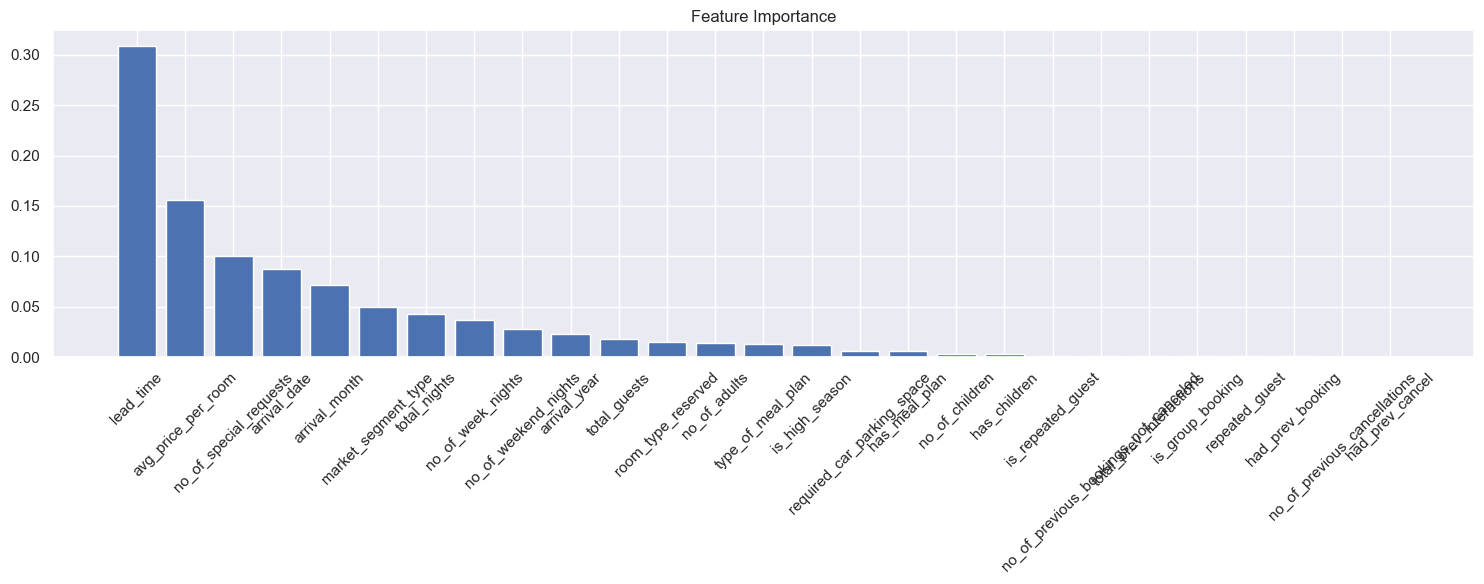

In [120]:
feature_names = X_train.columns

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(15, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='b', align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


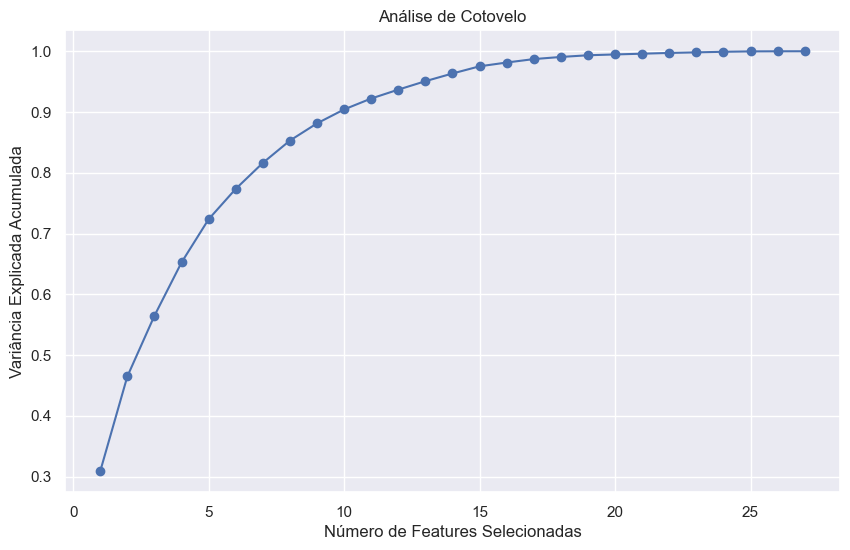

In [121]:
num_features = len(importances)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features + 1), np.cumsum(sorted_importances), marker='o', linestyle='-')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Análise de Cotovelo')
plt.grid(True)
plt.show()

## 5.2 Feature Importance - Regularização das Regressões

### 5.2.1 Lasso

In [122]:
# Treina o modelo
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Cria uma série com os coeficientes e nomes das variáveis
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)

# Filtra apenas as features relevantes (coeficiente ≠ 0)
selected_lasso_features = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)

# Mostra as features selecionadas
print(selected_lasso_features)


lead_time             0.002432
avg_price_per_room    0.002217
arrival_month        -0.002008
dtype: float64


## 5.3 Boruta

In [123]:
rf = RandomForestClassifier(n_jobs=-1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	21
I

In [124]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['lead_time',
 'arrival_month',
 'arrival_date',
 'avg_price_per_room',
 'no_of_special_requests']

In [125]:
boruta_columns = ['lead_time',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'avg_price_per_room',
 'no_of_special_requests']

# 6.0 Machine Learning

In [126]:
df6 = df5.copy()

In [127]:
X = df6[boruta_columns]
y = df6['booking_status']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [147]:
resultados_modelos = train_and_evaluate_models(X_train, y_train, X_test, y_test)
display(resultados_modelos)

[LightGBM] [Info] Number of positive: 10102, number of negative: 20731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 30833, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327636 -> initscore=-0.718897
[LightGBM] [Info] Start training from score -0.718897


c:\Users\mikar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Algoritmo,Precision,Recall,Accuracy
0,Random Forest,0.868185,0.812675,0.898199
1,Logistic Regression,0.764006,0.611890,0.810915
2,Decision Tree,0.801913,0.799215,0.869533
3,LightGBM,0.850433,0.771733,0.880742
4,XGBoost,0.855562,0.780707,0.884969


# 7.0 Fine Tuning

In [ ]:
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': max(min(max_features, 0.999), 0.01),  # para garantir faixa válida
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()
    return score

pbounds = {
    'n_estimators': (100, 250),
    'max_depth': (5, 20),
    'min_samples_split': (5, 15),
    'min_samples_leaf': (2, 10),
    'max_features': (0.3, 0.9)
}

optimizer_rf = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer_rf.maximize(init_points=5, n_iter=50)


|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | max_fe... |
-------------------------------------------------------------------------------------
| 2         | 0.7463852 | 143.63502 | 28.767857 | 7.8559515 | 6.3879263 | 0.2402607 |
| 3         | 0.6862973 | 88.998630 | 6.4520903 | 8.9294091 | 6.4100351 | 0.7365572 |
| 4         | 0.7676685 | 55.146123 | 29.247746 | 8.6595411 | 2.9110519 | 0.2634606 |
| 5         | 0.7554915 | 95.851127 | 12.606056 | 6.1980514 | 4.8875051 | 0.3618149 |
| 6         | 0.7068878 | 202.96322 | 8.4873465 | 4.3371571 | 4.2972565 | 0.5100069 |
| 7         | 0.6549171 | 201.88621 | 5.1334785 | 8.2835602 | 6.6847617 | 0.5052006 |
| 8         | 0.7871693 | 54.365498 | 26.145304 | 9.5125274 | 1.0       | 0.8437300 |
| 9         | 0.7877638 | 51.229562 | 23.265681 | 4.6654508 | 1.2277038 | 0.2586892 |
| 10        | 0.7774686 | 55.230831 | 16.817151 | 10.0      | 3.6001999 | 0.999     |
| 11        | 0.7982558 | 61.776833 | 21.147690 | 2.0 

In [ ]:
print('Melhores Parametros: ')
optimizer_rf.max['params']

Melhores Parametros: 


{'n_estimators': 193.7444687324753,
 'max_depth': 30.0,
 'min_samples_split': 2.0,
 'min_samples_leaf': 1.0,
 'max_features': 0.9989999999999999}

In [ ]:
best_params = optimizer_rf.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_features'] = int(best_params['max_features'])
print(best_params)

{'n_estimators': 193, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0}


In [132]:
best_params = {'n_estimators': 193, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.99}

# 8.0 Final Model

In [133]:
model_tunned = RandomForestClassifier(**best_params).fit(X_train, y_train)
y_pred = model_tunned.predict(X_test)
print('Precisao em dados de teste:', precision_score(y_test, model_tunned.predict(X_test)))
print('Recall em dados de teste:', recall_score(y_test, model_tunned.predict(X_test)))

Precisao em dados de teste: 0.8570588235294118
Recall em dados de teste: 0.8171620863712844


In [136]:
scores = cross_val_score(model_tunned, X_train, y_train, cv=5, scoring='recall')
print(f"Recall médio (CV): {scores.mean():.3f} ± {scores.std():.3f}")


Recall médio (CV): 0.800 ± 0.009


Sem sinais de overfitting: os resultados são consistentes entre treino, validação cruzada e teste.
A diferença de recall entre treino e teste é pequena e aceitável.

In [137]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [139]:
final_model = RandomForestClassifier(**best_params).fit(X_full, y_full)
pickle.dump(final_model, open('model/final_model.pkl', 'wb'))


# Deploy

In [ ]:
numeric_features = [
    'lead_time', 'no_of_adults', 'no_of_children',
    'no_of_week_nights', 'no_of_weekend_nights',
    'avg_price_per_room', 'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled', 'no_of_special_requests'
]

class PredictCancel(object):
    def __init__(self):
        # Scalers usados nos atributos finais
        self.scaler = pickle.load(open('parameter/hotelsmart_scaler.pkl', 'rb'))

        # Encoders
        self.market_segment_type = pickle.load(open('parameter/market_segment_type_encoder.pkl', 'rb'))

        # Imputer
        self.imputer_knn = pickle.load(open('../parameter/imputer_knn.pkl', 'rb'))

    def data_cleaning(self, df1):
        num_attributes = df1.select_dtypes(include=['int64', 'float64'])
        cat_attributes = df1.select_dtypes(include=['object', 'category'])

        if num_attributes.isnull().any().any():
            df_imputed = pd.DataFrame(
                self.imputer_knn.transform(num_attributes),
                columns=num_attributes.columns
            )
            df1 = pd.concat([df_imputed, cat_attributes], axis=1)
        return df1

    def feature_engineering(self, df2):
        df2["total_nights"] = df2["no_of_weekend_nights"] + df2["no_of_week_nights"]
        df2["total_guests"] = df2["no_of_adults"] + df2["no_of_children"]
        df2["lead_time_category"] = pd.cut(df2["lead_time"], bins=[-1, 7, 30, 90, 180, 365, 500],
                                        labels=["curto", "baixo", "medio", "alto", "muito_alto", "extremo"])
        df2["is_group_booking"] = (df2["total_guests"] >= 4).astype(int)
        df2["total_prev_interactions"] = df2["no_of_previous_cancellations"] + df2["no_of_previous_bookings_not_canceled"]
        df2["has_children"] = (df2["no_of_children"] > 0).astype(int)
        df2["has_meal_plan"] = (df2["type_of_meal_plan"] != "Not Selected").astype(int)
        df2["is_high_season"] = df2["arrival_month"].isin([1, 7, 8, 12]).astype(int)
        df2["had_prev_cancel"] = (df2["no_of_previous_cancellations"] > 0).astype(int)
        df2["had_prev_booking"] = (df2["no_of_previous_bookings_not_canceled"] > 0).astype(int)
        df2["is_repeated_guest"] = (df2["repeated_guest"] == 1).astype(int)

        return df2

    def data_preparation(self, df3):
        numeric_features = [
        'lead_time', 'no_of_adults', 'no_of_children',
        'no_of_week_nights', 'no_of_weekend_nights',
        'avg_price_per_room', 'no_of_previous_cancellations',
        'no_of_previous_bookings_not_canceled', 'no_of_special_requests']
        df3[numeric_features] = self.scaler.transform(df3[numeric_features])

        # Encoders
        df3[['market_segment_type']] = self.market_segment_type.transform(df3[['market_segment_type']])

        boruta_columns = ['lead_time',
        'arrival_month',
        'arrival_date',
        'market_segment_type',
        'avg_price_per_room',
        'no_of_special_requests']

        return df3[boruta_columns]
    
    def get_predictions(self, model, test_data, original_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred
        return original_data.to_json(orient='records')


# API Handler

In [150]:
# Carregar o modelo
model = pickle.load(open('model/final_model.pkl', 'rb'))

app = Flask(__name__)

@app.route('/code', methods=['POST'])
def cancel_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        pipeline = PredictCancel()
        df_cleaning = pipeline.data_cleaning(test_raw)
        df_feature = pipeline.feature_engineering(df_cleaning)
        df_preparation = pipeline.data_preparation(df_feature)
        df_predict = pipeline.get_predictions(model, df_preparation, test_raw)

        return df_predict
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.250:5000
Press CTRL+C to quit


# Test API

In [186]:
data_test = df1.loc[df1.index == 20]
model = pickle.load(open('model/final_model.pkl', 'rb'))


In [215]:
url = 'https://additional-fish-anagntto-1147e51d.koyeb.app/codes'
header = {'Content-type': 'application/json'}
data = json.dumps(data_test.to_dict(orient='records'))

r = requests.post(url, data=data, headers=header)
print('status code {}'.format(r.status_code))


status code 524


In [196]:
pipeline = PredictCancel()
df_cleaning = pipeline.data_cleaning(data_test)
df_feature = pipeline.feature_engineering(df_cleaning)
df_preparation = pipeline.data_preparation(df_feature)
df_predict = pipeline.get_predictions(model, df_preparation, data_test)

C:\Users\mikar\AppData\Local\Temp\ipykernel_10680\1145801649.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["total_nights"] = df2["no_of_weekend_nights"] + df2["no_of_week_nights"]
C:\Users\mikar\AppData\Local\Temp\ipykernel_10680\1145801649.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["total_guests"] = df2["no_of_adults"] + df2["no_of_children"]
C:\Users\mikar\AppData\Local\Temp\ipykernel_10680\1145801649.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [214]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,total_nights,total_guests,is_group_booking,total_prev_interactions,has_children,has_meal_plan,is_high_season,had_prev_cancel,had_prev_booking,is_repeated_guest,prediction,lead_time_category
0,-9.303082,-2.523667,-0.198645,-2.742452,0.0,-1.003409,2017.0,10.0,30.0,0.0,-0.702785,-0.165736,-3.032358,-3.065574,1.0,INN00021,Meal Plan 1,Room_Type 1,-1.0,-1.027208,-3.891475,0,-0.372818,0,1,0,0,0,0,0.0,curto
